In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

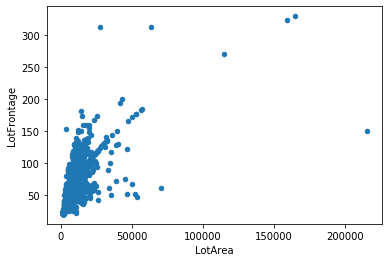

In [3]:
housing_prices_df_raw = pd.read_csv('../src/data/train.csv')
test_housing_prices_df_raw = pd.read_csv('../src/data/test.csv')

train_hdf = housing_prices_df_raw.copy()
test_hdf = test_housing_prices_df_raw.copy()

hdf = pd.concat([train_hdf, test_hdf], axis = 0, sort = False)
hdf_eda = hdf.copy()

## Inspect data frame

hdf.shape

hdf.head()

hdf.info()

## Identify features by variable type

ord_feat_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 
        'BsmtHalfBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces', 'BedroomAbvGr', 
        'KitchenAbvGr', 'GarageCars']

ord_feat_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC']

ord_feat = ord_feat_num + ord_feat_cat

nom_feat = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 
       'LandContour', 'Utilities', 'Neighborhood', 
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 
       'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 
       'HouseStyle','LotConfig', 'Street', 'LandSlope']

cont_feat = ['LotFrontage', 'LotArea', 'YearBuilt', 
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
       'MiscVal', 'MoSold', 'YrSold','BsmtUnfSF', 'GarageArea', 
       'LowQualFinSF', 'GrLivArea']

## Data cleaning

### Impute missing values

# Check NAs by count
NA_count = hdf.isnull().sum()[hdf.isnull().sum() > 0]

# By percentage
round(100*NA_count/len(hdf), 2)


# Create df with LotArea and LotFrontage
from sklearn.linear_model import LinearRegression
inp_LotFrontage = LinearRegression()
a = pd.DataFrame({'LotArea':  np.log1p(hdf['LotArea']), 'LotFrontage':np.log1p(hdf['LotFrontage'])})
a = a.loc[a['LotArea'] < 12.1,:]

# Splitting data by missing and non-missingness
a_train = a.loc[~a['LotFrontage'].isnull(),:]
a_inp = a.loc[a['LotFrontage'].isnull(),:]

# Generate values to impute by fitting a model
inp_LotFrontage.fit(a_train[['LotArea']], a_train['LotFrontage'])

# Impute values
hdf.loc[hdf['LotFrontage'].isnull(), 'LotFrontage'] = np.expm1(inp_LotFrontage.predict(a_inp[['LotArea']]))

hdf.plot(kind = 'scatter', x = 'LotArea', y = 'LotFrontage')

# Convert ord_feat_num to ord_feat
hdf[ord_feat_cat] = hdf[ord_feat_cat].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
hdf[['BsmtExposure']] = hdf[['BsmtExposure']].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
hdf[['BsmtFinType1', 'BsmtFinType2']] = hdf[['BsmtFinType1', 'BsmtFinType2']].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})

# Convert fence to nominal
hdf[['Fence']] = hdf[['Fence']].replace({'MnPrv': 'HasFence', 'GdWo': 'HasFence', 'GdPrv': 'HasFence', 'MnWw': 'HasFence', np.nan: 'NoFence'})


from scipy import stats

for col in set(hdf.columns) - {'SalePrice'}:
    if hdf[col].dtype == 'object':
        hdf.fillna({col:stats.mode(hdf[col]).mode[0]}, inplace = True)
    else:
        hdf.fillna({col:np.median(hdf.loc[~hdf[col].isnull(), col])}, inplace = True)

## Data preprocessing

### Generate features

hdf['Remodeled'] = pd.Series([1 if a > 0 else 0 for a in (hdf['YearRemodAdd'] - hdf['YearBuilt'])])
hdf['TotalPorchAreasSF'] = hdf['OpenPorchSF'] + hdf['EnclosedPorch'] + hdf['3SsnPorch'] + hdf['ScreenPorch'] + hdf['WoodDeckSF']
hdf ['TotalBath'] = hdf['FullBath'] + hdf['BsmtFullBath'] + .5*(hdf['HalfBath'] + hdf['BsmtHalfBath'])
hdf['OtherRoomsAbvGrd'] = hdf['TotRmsAbvGrd'] - hdf['KitchenAbvGr'] - hdf['FullBath']


hdf.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace = True)
hdf.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace = True) # There is totalbsmt
hdf.drop(columns = ['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'], inplace = True)
hdf.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], inplace = True)
hdf.drop(columns = 'MiscFeature', inplace = True) # Drop feature (since price of feature is in Miscval)
hdf.drop(columns = 'TotRmsAbvGrd', inplace = True)

round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)


ord_feat_num = set(ord_feat_num).union(set(['TotalBath', 'OtherRoomsAbvGrd', 'Remodeled'])) - \
set(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',' KitchenAbvGr', 'GarageCars'])

ord_feat_cat = set(ord_feat_cat) - set(['PoolQC'])

ord_feat = ord_feat_num.union(ord_feat_cat)

nom_feat = set(nom_feat) - set(['Utilities','MiscFeature','Street'])

cont_feat = list(set(cont_feat).union(set(['TotalPorchAreasSF'])) - set(['Utilities', 'Street', 'PoolQC'] +\
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] +\
['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'] +\
['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'] +\
['MiscFeature', 'TotRmsAbvGrd']))

In [ ]:
# housing_prices_df_raw = pd.read_csv('../src/data/train.csv')
test_housing_prices_df_raw = pd.read_csv('../src/data/test.csv')

In [6]:
train_hdf = housing_prices_df_raw.copy()
test_hdf = test_housing_prices_df_raw.copy()
hdf = pd.concat([train_hdf, test_hdf], axis = 0, sort = False)

# Feature Selection/Data Wragling

In [7]:
ord_feat_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 
        'BsmtHalfBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces', 'BedroomAbvGr', 
        'KitchenAbvGr', 'GarageCars']

ord_feat_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC']

ord_feat = ord_feat_num + ord_feat_cat

nom_feat = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 
       'LandContour', 'Utilities', 'Neighborhood', 
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 
       'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 
       'HouseStyle','LotConfig', 'Street', 'LandSlope']

cat_feat = nom_feat + ord_feat

cont_feat = ['LotFrontage', 'LotArea', 'YearBuilt', 
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
       'MiscVal', 'MoSold', 'YrSold','BsmtUnfSF', 'GarageArea', 
       'LowQualFinSF', 'GrLivArea']

In [8]:
hdf['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

## Filling NA's

In [9]:
# hdf.loc[:,hdf.isnull().sum() > 0]
# hdf.isnull().sum()[hdf.isnull().sum() > 0]

In [10]:
# In percentage
print(hdf.shape)
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

(2919, 81)


MSZoning         0.14
LotFrontage     16.65
Alley           93.22
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.77
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.65
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.66
Fence           80.44
MiscFeature     96.40
SaleType         0.03
SalePrice       49.98
dtype: float64

In [11]:
from scipy import stats


hdf[ord_feat_cat] = hdf[ord_feat_cat].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
hdf[['BsmtExposure']] = hdf[['BsmtExposure']].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
hdf[['BsmtFinType1', 'BsmtFinType2']] = hdf[['BsmtFinType1', 
                                             'BsmtFinType2']].replace({'GLQ': 6, 'ALQ': 5, 
                                                                       'BLQ': 4, 'Rec': 3, 
                                                                       'LwQ': 2, 'Unf': 1, 
                                                                       np.nan:0})
hdf[['Fence']] = hdf[['Fence']].replace({'MnPrv': 'HasFence', 
                                         'GdWo': 'HasFence', 
                                         'GdPrv': 'HasFence', 
                                         'MnWw': 'HasFence',
                                          np.nan: 'NoFence'})


# Inpute LotFrontage
a = hdf.groupby('Neighborhood')['LotFrontage'].agg('median')

hdf['LotFrontage'] = hdf.apply(lambda row: a.loc[row['Neighborhood']] if 
          np.isnan(row['LotFrontage']) else row['LotFrontage'], axis = 1)



for col in set(hdf.columns) - {'SalePrice'}:
    if hdf[col].dtype == 'object':
        hdf.fillna({col:stats.mode(hdf[col]).mode[0]}, inplace = True)
    else:
        hdf.fillna({col:np.median(hdf.loc[~hdf[col].isnull(), col])}, inplace = True)
        
        
# hdf.fillna({'PoolQC':}, inplace = True)
# hdf.fillna({'FireplaceQu':0}, inplace = True)
# hdf.fillna({'Alley':0}, inplace = True)
# hdf.fillna({gar:'NoGar' for gar in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']}, inplace=True)
# hdf.fillna({'GarageYrBlt':int(stats.mode(hdf['GarageYrBlt']).mode[0])}, inplace = True)
# hdf.fillna({bsmt:'NoBsmt' for bsmt in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']},
#             inplace = True)

In [12]:
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

SalePrice    49.98
dtype: float64

# Feature generation

In [13]:
hdf['remodeled'] = pd.Series([1 if a > 0 else 0 for a in (hdf['YearRemodAdd'] - hdf['YearBuilt'])])
hdf['TotalPorchAreasSF'] = hdf['OpenPorchSF'] + hdf['EnclosedPorch'] + hdf['3SsnPorch'] + hdf['ScreenPorch'] + \
                              hdf['WoodDeckSF']
hdf ['TotalBath'] = hdf['FullBath'] + hdf['BsmtFullBath'] + .5*(hdf['HalfBath'] + hdf['BsmtHalfBath'])
hdf['RestRooms'] = hdf['TotRmsAbvGrd'] - hdf['KitchenAbvGr'] - hdf['FullBath']

In [14]:
hdf.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace = True)
hdf.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace = True) #there is totalbsmt
hdf.drop(columns = ['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'], inplace = True)
hdf.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], inplace = True)
hdf.drop(columns = 'MiscFeature', inplace = True) # drop feature (since price of feature is in miscval)
hdf.drop(columns = 'TotRmsAbvGrd', inplace = True)

In [15]:
cat_feat = set(cat_feat) - set(['MiscFeature', 'Utilities', 'Street', 
                                'FullBath', 'PoolQC', 'HalfBath', 'BsmtHalfBath', 
                                'BsmtFullBath', 'PoolQC', 'TotRmsAbvGrd'])

cont_feat = list(set(cont_feat) - set(['Utilities', 'Street', 'PoolQC'] +\
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] +\
['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'] +\
['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'] +\
['MiscFeature', 'TotRmsAbvGrd']))


nom_feat = list(set(nom_feat) - set(['MiscFeature', 'Utilities', 'Street']))

# Train and test split/Remove outliers

In [16]:
# Dummify and Transforming prine to log price
X = pd.get_dummies(hdf, columns = nom_feat, drop_first=True)

X_train = X.loc[~X['SalePrice'].isnull(), :]


# #Removing Outliers
X_train = X_train.loc[(X_train['GrLivArea'] < 4000) & (X_train['LotArea'] < 100000) & (X_train['LotFrontage'] < 250),:]


y_train = np.log1p(X_train.loc[~X_train['SalePrice'].isnull(), 'SalePrice']) ## log price here!!

X_train.drop(columns = ['Id', 'SalePrice'], inplace = True)
X_test = X.loc[X['SalePrice'].isnull(), :].drop(columns = ['SalePrice'])

In [17]:
round(X_test.isnull().sum()[X_test.isnull().sum() > 0])

Series([], dtype: int64)

# Normalization of the columns if needed

In [18]:
# # Normalization. Use this one instead of the model option since we have to normalize the test dataset as well.
for col in X_train.columns:
    if np.std(X_train[col]) != 0:
        X_train[col] = (X_train[col] - np.mean(X_train[col]))/np.std(X_train[col], ddof=1)
    if np.std(X_test[col]) != 0:
        X_test[col] = (X_test[col] - np.mean(X_test[col]))/np.std(X_test[col], ddof=1)

# ------------------------------------------------------------------------------------------

# Initialize

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Drop columns with low variance/Not advised

In [20]:
vr = []
for col in X.columns:
    vr.append((np.var(X[col]), col))

In [21]:
X_LV = X.copy()
X_LV = X_LV.drop(columns = list(map(lambda x: x[1], filter(lambda x: x[0] > .8*(1-.8), vr))))

In [22]:
# Normalization
for col in X_LV.columns:
    X_LV[col] = (X_LV[col] - np.mean(X_LV[col]))/np.std(X_LV[col], ddof=1)

# Lasso feature selection

In [23]:
from sklearn.linear_model import Lasso
import seaborn as sns

In [24]:
lasso_lm = Lasso(max_iter=1e7, warm_start=True, normalize = True)

In [25]:
## Try this as well. takes a long time!
lasso_coefs = []
alphas      = np.logspace(-6, 1, 1000)

In [26]:
# lasso_coefs = []
# alphas      = np.logspace(-2, 0.5, 2)

In [27]:
for alpha in alphas:
    lasso_lm.set_params(alpha = alpha).fit(X_train, y_train)
    lasso_coefs.append(lasso_lm.coef_)

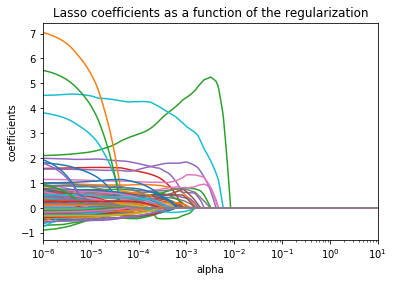

In [28]:
df_coef = pd.DataFrame(lasso_coefs, index=alphas, columns = X_train.columns)
title = 'Lasso coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title, legend = False)
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.show()

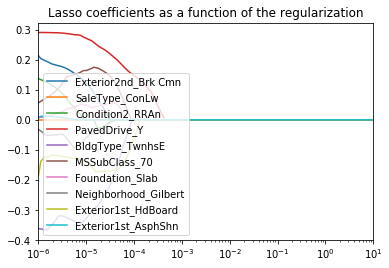

In [29]:
df_coef.iloc[:, np.random.choice(range(df_coef.shape[1]), size = 10, replace = False)].plot(logx=True, title=title)

In [30]:
coef_orders = []
for row in df_coef.index:
    coef_orders.extend([list(df_coef.loc[:,df_coef.loc[row, :] > 0.001].columns)])

In [31]:
last = []
s = 0
for i in sorted(np.unique(coef_orders), key = len):
    print (set(i) - set(last))
    s += len(set(i) - set(last))
    last = i


set()
{'OverallQual'}
{'GrLivArea'}
{'TotalBath'}
{'GarageCars'}
{'TotalBsmtSF'}
{'KitchenQual'}
{'GarageArea'}
{'YearBuilt'}
{'ExterQual'}
{'YearRemodAdd'}
{'FireplaceQu', '1stFlrSF'}
{'LotArea'}
{'CentralAir_Y'}
{'BsmtFinType1', 'Fireplaces', 'MSZoning_RL'}
{'1stFlrSF'}
{'BsmtFinType1'}
{'HeatingQC'}
{'BsmtQual', '1stFlrSF'}
{'OverallCond', 'TotalPorchAreasSF'}
{'BsmtExposure'}
{'Neighborhood_Crawfor'}
{'GarageQual'}
{'SaleType_New'}
{'LotFrontage'}
{'Foundation_PConc'}
{'Functional_Typ'}
{'PavedDrive_Y'}
{'Condition1_Norm'}
{'Neighborhood_NridgHt'}
{'Exterior1st_BrkFace', 'Neighborhood_StoneBr'}
{'MasVnrType_Stone'}
{'SaleCondition_Normal'}
{'LotConfig_CulDSac'}
{'MasVnrArea'}
{'Neighborhood_Somerst'}
{'BsmtQual'}
{'MSZoning_FV', 'Neighborhood_Somerst'}
{'Neighborhood_BrkSide'}
{'Neighborhood_Veenker', 'RestRooms'}
{'BsmtQual'}
{'Exterior1st_MetalSd', 'Neighborhood_Veenker'}
{'BsmtQual'}
{'Exterior1st_MetalSd'}
{'Heating_GasW'}
{'Neighborhood_NoRidge'}
{'Neighborhood_ClearCr'}
{'Sal

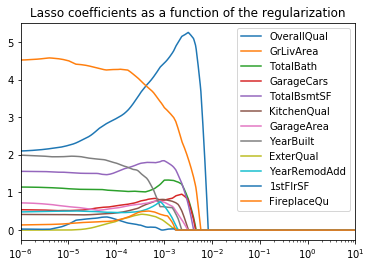

In [32]:
df_coef.loc[:, ['OverallQual','GrLivArea', 'TotalBath', 
                 'GarageCars', 'TotalBsmtSF','KitchenQual',
                 'GarageArea', 'YearBuilt', 'ExterQual',
                 'YearRemodAdd', '1stFlrSF', 'FireplaceQu']].plot(logx=True, title=title)

In [33]:
sorted(X_train['OverallQual'].unique())

[-3.710538370324534,
 -2.9811979239223527,
 -2.251857477520172,
 -1.5225170311179912,
 -0.7931765847158104,
 -0.06383613831362964,
 0.6655043080885511,
 1.3948447544907319,
 2.1241852008929127,
 2.8535256472950934]

In [34]:
# sns.pairplot(hdf[['YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea']])

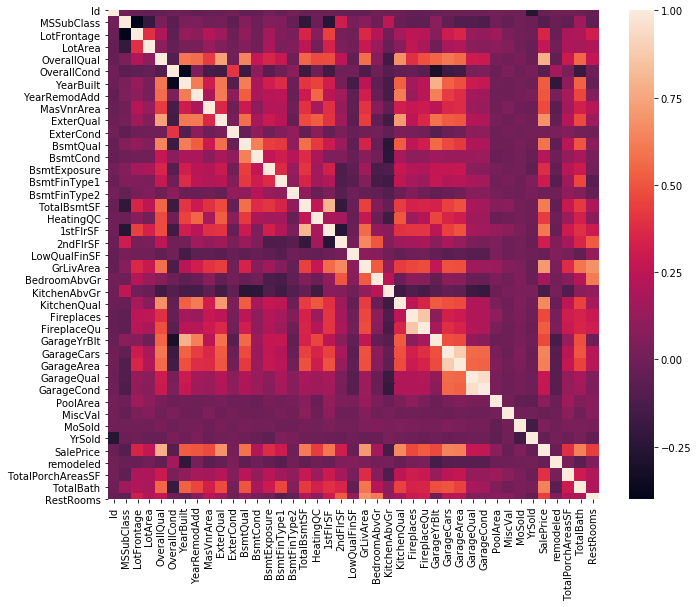

In [35]:
corr = hdf.corr()

f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(corr)

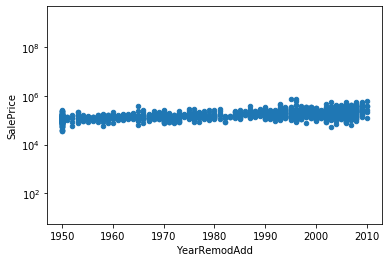

In [36]:
hdf.plot(kind = 'scatter', x = 'YearRemodAdd', y =  'SalePrice', logy = True)

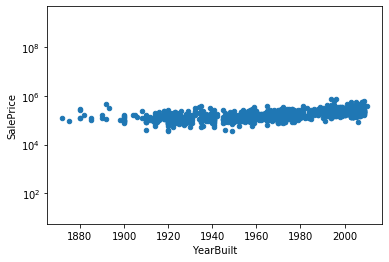

In [37]:
hdf.plot(kind = 'scatter', x = 'YearBuilt', y =  'SalePrice', logy = True)

# Grid search CV in lasso regression

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [39]:
lasso_gs = Lasso(max_iter = 1e7, warm_start = True, normalize = True)

In [40]:
grid_params = [{'alpha': np.logspace(-6, -2, 1000)}]

In [41]:
lasso_param_search = GridSearchCV(estimator = lasso_gs, 
                                  param_grid = grid_params, cv=10, 
                                  return_train_score=True,
                                  scoring='r2', verbose=2)

In [42]:
lasso_param_search.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.4s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.4s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.4s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] .

[CV] ..................... alpha=1.0471768194855203e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] ...................... alpha=1.056875971184805e-06, total=   0.4s
[CV] alpha=1.056875971184805e-06 .....................................
[CV] .

[CV] ..................... alpha=1.1067360180959745e-06, total=   0.4s
[CV] alpha=1.1067360180959745e-06 ....................................
[CV] ..................... alpha=1.1067360180959745e-06, total=   0.4s
[CV] alpha=1.1067360180959745e-06 ....................................
[CV] ..................... alpha=1.1067360180959745e-06, total=   0.4s
[CV] alpha=1.1169868184678225e-06 ....................................
[CV] ..................... alpha=1.1169868184678225e-06, total=   0.4s
[CV] alpha=1.1169868184678225e-06 ....................................
[CV] ..................... alpha=1.1169868184678225e-06, total=   0.4s
[CV] alpha=1.1169868184678225e-06 ....................................
[CV] ..................... alpha=1.1169868184678225e-06, total=   0.4s
[CV] alpha=1.1169868184678225e-06 ....................................
[CV] ..................... alpha=1.1169868184678225e-06, total=   0.5s
[CV] alpha=1.1169868184678225e-06 ....................................
[CV] .

[CV] ..................... alpha=1.1696827039703847e-06, total=   0.4s
[CV] alpha=1.1696827039703847e-06 ....................................
[CV] ..................... alpha=1.1696827039703847e-06, total=   0.4s
[CV] alpha=1.1696827039703847e-06 ....................................
[CV] ..................... alpha=1.1696827039703847e-06, total=   0.4s
[CV] alpha=1.1696827039703847e-06 ....................................
[CV] ..................... alpha=1.1696827039703847e-06, total=   0.4s
[CV] alpha=1.1696827039703847e-06 ....................................
[CV] ..................... alpha=1.1696827039703847e-06, total=   0.3s
[CV] alpha=1.1805165285688055e-06 ....................................
[CV] ..................... alpha=1.1805165285688055e-06, total=   0.4s
[CV] alpha=1.1805165285688055e-06 ....................................
[CV] ..................... alpha=1.1805165285688055e-06, total=   0.4s
[CV] alpha=1.1805165285688055e-06 ....................................
[CV] .

[CV] ...................... alpha=1.236209543736769e-06, total=   0.4s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.3s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.4s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.4s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.4s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.4s
[CV] alpha=1.236209543736769e-06 .....................................
[CV] ...................... alpha=1.236209543736769e-06, total=   0.3s
[CV] alpha=1.2476595526308684e-06 ....................................
[CV] .

[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.4s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] ..................... alpha=1.3065201621247199e-06, total=   0.3s
[CV] alpha=1.3065201621247199e-06 ....................................
[CV] .

[CV] ..................... alpha=1.3681576279674705e-06, total=   0.4s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.4s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.3s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.4s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.3s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.3s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] ..................... alpha=1.3808297652180924e-06, total=   0.3s
[CV] alpha=1.3808297652180924e-06 ....................................
[CV] .

[CV] ..................... alpha=1.4459729217920196e-06, total=   0.3s
[CV] alpha=1.4459729217920196e-06 ....................................
[CV] ..................... alpha=1.4459729217920196e-06, total=   0.3s
[CV] alpha=1.4459729217920196e-06 ....................................
[CV] ..................... alpha=1.4459729217920196e-06, total=   0.3s
[CV] alpha=1.4593657991557576e-06 ....................................
[CV] ..................... alpha=1.4593657991557576e-06, total=   0.3s
[CV] alpha=1.4593657991557576e-06 ....................................
[CV] ..................... alpha=1.4593657991557576e-06, total=   0.3s
[CV] alpha=1.4593657991557576e-06 ....................................
[CV] ..................... alpha=1.4593657991557576e-06, total=   0.3s
[CV] alpha=1.4593657991557576e-06 ....................................
[CV] ..................... alpha=1.4593657991557576e-06, total=   0.3s
[CV] alpha=1.4593657991557576e-06 ....................................
[CV] .

[CV] ..................... alpha=1.5282140360258708e-06, total=   0.3s
[CV] alpha=1.5282140360258708e-06 ....................................
[CV] ..................... alpha=1.5282140360258708e-06, total=   0.3s
[CV] alpha=1.5282140360258708e-06 ....................................
[CV] ..................... alpha=1.5282140360258708e-06, total=   0.3s
[CV] alpha=1.5282140360258708e-06 ....................................
[CV] ..................... alpha=1.5282140360258708e-06, total=   0.3s
[CV] alpha=1.5282140360258708e-06 ....................................
[CV] ..................... alpha=1.5282140360258708e-06, total=   0.3s
[CV] alpha=1.5423686462966274e-06 ....................................
[CV] ..................... alpha=1.5423686462966274e-06, total=   0.3s
[CV] alpha=1.5423686462966274e-06 ....................................
[CV] ..................... alpha=1.5423686462966274e-06, total=   0.3s
[CV] alpha=1.5423686462966274e-06 ....................................
[CV] .

[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.6151326935030896e-06 ....................................
[CV] ..................... alpha=1.6151326935030896e-06, total=   0.3s
[CV] alpha=1.630092360979741e-06 .....................................
[CV] .

[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] ..................... alpha=1.7069949340384078e-06, total=   0.3s
[CV] alpha=1.7069949340384078e-06 ....................................
[CV] .

[CV] ..................... alpha=1.7875255259042354e-06, total=   0.2s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.3s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.2s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.3s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.3s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.2s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] ...................... alpha=1.804081928719381e-06, total=   0.3s
[CV] alpha=1.804081928719381e-06 .....................................
[CV] .

[CV] ..................... alpha=1.8891927762076644e-06, total=   0.3s
[CV] alpha=1.8891927762076644e-06 ....................................
[CV] ..................... alpha=1.8891927762076644e-06, total=   0.3s
[CV] alpha=1.8891927762076644e-06 ....................................
[CV] ..................... alpha=1.8891927762076644e-06, total=   0.2s
[CV] alpha=1.906690840512252e-06 .....................................
[CV] ...................... alpha=1.906690840512252e-06, total=   0.3s
[CV] alpha=1.906690840512252e-06 .....................................
[CV] ...................... alpha=1.906690840512252e-06, total=   0.2s
[CV] alpha=1.906690840512252e-06 .....................................
[CV] ...................... alpha=1.906690840512252e-06, total=   0.2s
[CV] alpha=1.906690840512252e-06 .....................................
[CV] ...................... alpha=1.906690840512252e-06, total=   0.2s
[CV] alpha=1.906690840512252e-06 .....................................
[CV] .

[CV] ..................... alpha=1.9966424501097934e-06, total=   0.2s
[CV] alpha=1.9966424501097934e-06 ....................................
[CV] ..................... alpha=1.9966424501097934e-06, total=   0.2s
[CV] alpha=1.9966424501097934e-06 ....................................
[CV] ..................... alpha=1.9966424501097934e-06, total=   0.2s
[CV] alpha=1.9966424501097934e-06 ....................................
[CV] ..................... alpha=1.9966424501097934e-06, total=   0.2s
[CV] alpha=1.9966424501097934e-06 ....................................
[CV] ..................... alpha=1.9966424501097934e-06, total=   0.2s
[CV] alpha=2.0151357338155584e-06 ....................................
[CV] ..................... alpha=2.0151357338155584e-06, total=   0.2s
[CV] alpha=2.0151357338155584e-06 ....................................
[CV] ..................... alpha=2.0151357338155584e-06, total=   0.2s
[CV] alpha=2.0151357338155584e-06 ....................................
[CV] .

[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1102034285685966e-06 ....................................
[CV] ..................... alpha=2.1102034285685966e-06, total=   0.2s
[CV] alpha=2.1297485357455187e-06 ....................................
[CV] .

[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] ..................... alpha=2.2302232979659364e-06, total=   0.2s
[CV] alpha=2.2302232979659364e-06 ....................................
[CV] .

[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] ...................... alpha=2.357069413996728e-06, total=   0.2s
[CV] alpha=2.357069413996728e-06 .....................................
[CV] .

[CV] ..................... alpha=2.4682684522556926e-06, total=   0.2s
[CV] alpha=2.4682684522556926e-06 ....................................
[CV] ..................... alpha=2.4682684522556926e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] ...................... alpha=2.491130026067791e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] ...................... alpha=2.491130026067791e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] ...................... alpha=2.491130026067791e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] ...................... alpha=2.491130026067791e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] ...................... alpha=2.491130026067791e-06, total=   0.2s
[CV] alpha=2.491130026067791e-06 .....................................
[CV] .

[CV] ..................... alpha=2.6086536176225505e-06, total=   0.2s
[CV] alpha=2.6086536176225505e-06 ....................................
[CV] ..................... alpha=2.6086536176225505e-06, total=   0.2s
[CV] alpha=2.6086536176225505e-06 ....................................
[CV] ..................... alpha=2.6086536176225505e-06, total=   0.2s
[CV] alpha=2.6086536176225505e-06 ....................................
[CV] ..................... alpha=2.6086536176225505e-06, total=   0.2s
[CV] alpha=2.63281546564802e-06 ......................................
[CV] ....................... alpha=2.63281546564802e-06, total=   0.2s
[CV] alpha=2.63281546564802e-06 ......................................
[CV] ....................... alpha=2.63281546564802e-06, total=   0.2s
[CV] alpha=2.63281546564802e-06 ......................................
[CV] ....................... alpha=2.63281546564802e-06, total=   0.2s
[CV] alpha=2.63281546564802e-06 ......................................
[CV] .

[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.7570233256095828e-06 ....................................
[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.7570233256095828e-06 ....................................
[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.7570233256095828e-06 ....................................
[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.7570233256095828e-06 ....................................
[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.7570233256095828e-06 ....................................
[CV] ..................... alpha=2.7570233256095828e-06, total=   0.2s
[CV] alpha=2.782559402207126e-06 .....................................
[CV] ...................... alpha=2.782559402207126e-06, total=   0.2s
[CV] alpha=2.782559402207126e-06 .....................................
[CV] .

[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] ..................... alpha=2.9138317048327886e-06, total=   0.2s
[CV] alpha=2.9138317048327886e-06 ....................................
[CV] .

[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] ..................... alpha=3.0795587129142233e-06, total=   0.2s
[CV] alpha=3.0795587129142233e-06 ....................................
[CV] .

[CV] ..................... alpha=3.2248424984084387e-06, total=   0.1s
[CV] alpha=3.2248424984084387e-06 ....................................
[CV] ..................... alpha=3.2248424984084387e-06, total=   0.1s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] ...................... alpha=3.254711605531848e-06, total=   0.2s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] ...................... alpha=3.254711605531848e-06, total=   0.1s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] ...................... alpha=3.254711605531848e-06, total=   0.2s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] ...................... alpha=3.254711605531848e-06, total=   0.1s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] ...................... alpha=3.254711605531848e-06, total=   0.1s
[CV] alpha=3.254711605531848e-06 .....................................
[CV] .

[CV] ...................... alpha=3.408258547423452e-06, total=   0.2s
[CV] alpha=3.408258547423452e-06 .....................................
[CV] ...................... alpha=3.408258547423452e-06, total=   0.1s
[CV] alpha=3.408258547423452e-06 .....................................
[CV] ...................... alpha=3.408258547423452e-06, total=   0.1s
[CV] alpha=3.408258547423452e-06 .....................................
[CV] ...................... alpha=3.408258547423452e-06, total=   0.1s
[CV] alpha=3.4398264890229283e-06 ....................................
[CV] ..................... alpha=3.4398264890229283e-06, total=   0.2s
[CV] alpha=3.4398264890229283e-06 ....................................
[CV] ..................... alpha=3.4398264890229283e-06, total=   0.1s
[CV] alpha=3.4398264890229283e-06 ....................................
[CV] ..................... alpha=3.4398264890229283e-06, total=   0.2s
[CV] alpha=3.4398264890229283e-06 ....................................
[CV] .

[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6021065623570736e-06 ....................................
[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6021065623570736e-06 ....................................
[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6021065623570736e-06 ....................................
[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6021065623570736e-06 ....................................
[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6021065623570736e-06 ....................................
[CV] ..................... alpha=3.6021065623570736e-06, total=   0.1s
[CV] alpha=3.6354699612933177e-06 ....................................
[CV] ..................... alpha=3.6354699612933177e-06, total=   0.1s
[CV] alpha=3.6354699612933177e-06 ....................................
[CV] .

[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] ...................... alpha=3.806979871402284e-06, total=   0.1s
[CV] alpha=3.806979871402284e-06 .....................................
[CV] .

[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] ...................... alpha=4.023505548869293e-06, total=   0.1s
[CV] alpha=4.023505548869293e-06 .....................................
[CV] .

[CV] ...................... alpha=4.213321743847289e-06, total=   0.1s
[CV] alpha=4.213321743847289e-06 .....................................
[CV] ...................... alpha=4.213321743847289e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] ...................... alpha=4.252346334528686e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] ...................... alpha=4.252346334528686e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] ...................... alpha=4.252346334528686e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] ...................... alpha=4.252346334528686e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] ...................... alpha=4.252346334528686e-06, total=   0.1s
[CV] alpha=4.252346334528686e-06 .....................................
[CV] .

[CV] ....................... alpha=4.45295850994266e-06, total=   0.1s
[CV] alpha=4.45295850994266e-06 ......................................
[CV] ....................... alpha=4.45295850994266e-06, total=   0.1s
[CV] alpha=4.45295850994266e-06 ......................................
[CV] ....................... alpha=4.45295850994266e-06, total=   0.1s
[CV] alpha=4.45295850994266e-06 ......................................
[CV] ....................... alpha=4.45295850994266e-06, total=   0.1s
[CV] alpha=4.494202662119142e-06 .....................................
[CV] ...................... alpha=4.494202662119142e-06, total=   0.1s
[CV] alpha=4.494202662119142e-06 .....................................
[CV] ...................... alpha=4.494202662119142e-06, total=   0.1s
[CV] alpha=4.494202662119142e-06 .....................................
[CV] ...................... alpha=4.494202662119142e-06, total=   0.1s
[CV] alpha=4.494202662119142e-06 .....................................
[CV] .

[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.706224849841281e-06 .....................................
[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.706224849841281e-06 .....................................
[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.706224849841281e-06 .....................................
[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.706224849841281e-06 .....................................
[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.706224849841281e-06 .....................................
[CV] ...................... alpha=4.706224849841281e-06, total=   0.1s
[CV] alpha=4.749814803228504e-06 .....................................
[CV] ...................... alpha=4.749814803228504e-06, total=   0.1s
[CV] alpha=4.749814803228504e-06 .....................................
[CV] .

[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=4.973895958790067e-06 .....................................
[CV] ...................... alpha=4.973895958790067e-06, total=   0.1s
[CV] alpha=5.019965133110079e-06 .....................................
[CV] .

[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] ..................... alpha=5.2567911220184196e-06, total=   0.1s
[CV] alpha=5.2567911220184196e-06 ....................................
[CV] .

[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] ...................... alpha=5.555776222398878e-06, total=   0.1s
[CV] alpha=5.555776222398878e-06 .....................................
[CV] .

[CV] ...................... alpha=5.817880074344936e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] ...................... alpha=5.871766390733262e-06, total=   0.1s
[CV] alpha=5.871766390733262e-06 .....................................
[CV] .

[CV] ...................... alpha=6.148777653810029e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] ...................... alpha=6.205728806776501e-06, total=   0.1s
[CV] alpha=6.205728806776501e-06 .....................................
[CV] .

[CV] ..................... alpha=6.4984953544698886e-06, total=   0.1s
[CV] alpha=6.4984953544698886e-06 ....................................
[CV] ..................... alpha=6.4984953544698886e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] ...................... alpha=6.558685659571436e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] ...................... alpha=6.558685659571436e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] ...................... alpha=6.558685659571436e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] ...................... alpha=6.558685659571436e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] ...................... alpha=6.558685659571436e-06, total=   0.1s
[CV] alpha=6.558685659571436e-06 .....................................
[CV] .

[CV] ...................... alpha=6.868103588995307e-06, total=   0.1s
[CV] alpha=6.868103588995307e-06 .....................................
[CV] ...................... alpha=6.868103588995307e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] ..................... alpha=6.9317172761554005e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] ..................... alpha=6.9317172761554005e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] ..................... alpha=6.9317172761554005e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] ..................... alpha=6.9317172761554005e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] ..................... alpha=6.9317172761554005e-06, total=   0.1s
[CV] alpha=6.9317172761554005e-06 ....................................
[CV] .

[CV] ...................... alpha=7.258733650817246e-06, total=   0.1s
[CV] alpha=7.258733650817246e-06 .....................................
[CV] ...................... alpha=7.258733650817246e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] ....................... alpha=7.32596542821523e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] ....................... alpha=7.32596542821523e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] ....................... alpha=7.32596542821523e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] ....................... alpha=7.32596542821523e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] ....................... alpha=7.32596542821523e-06, total=   0.1s
[CV] alpha=7.32596542821523e-06 ......................................
[CV] .

[CV] ...................... alpha=7.671581176779302e-06, total=   0.1s
[CV] alpha=7.671581176779302e-06 .....................................
[CV] ...................... alpha=7.671581176779302e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] ...................... alpha=7.742636826811277e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] ...................... alpha=7.742636826811277e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] ...................... alpha=7.742636826811277e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] ...................... alpha=7.742636826811277e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] ...................... alpha=7.742636826811277e-06, total=   0.1s
[CV] alpha=7.742636826811277e-06 .....................................
[CV] .

[CV] ...................... alpha=8.107909806731694e-06, total=   0.1s
[CV] alpha=8.107909806731694e-06 .....................................
[CV] ...................... alpha=8.107909806731694e-06, total=   0.1s
[CV] alpha=8.107909806731694e-06 .....................................
[CV] ...................... alpha=8.107909806731694e-06, total=   0.1s
[CV] alpha=8.183006815867389e-06 .....................................
[CV] ...................... alpha=8.183006815867389e-06, total=   0.1s
[CV] alpha=8.183006815867389e-06 .....................................
[CV] ...................... alpha=8.183006815867389e-06, total=   0.1s
[CV] alpha=8.183006815867389e-06 .....................................
[CV] ...................... alpha=8.183006815867389e-06, total=   0.1s
[CV] alpha=8.183006815867389e-06 .....................................
[CV] ...................... alpha=8.183006815867389e-06, total=   0.1s
[CV] alpha=8.183006815867389e-06 .....................................
[CV] .

[CV] ...................... alpha=8.569055051268347e-06, total=   0.1s
[CV] alpha=8.569055051268347e-06 .....................................
[CV] ...................... alpha=8.569055051268347e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] ...................... alpha=8.648423275731726e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] ...................... alpha=8.648423275731726e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] ...................... alpha=8.648423275731726e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] ...................... alpha=8.648423275731726e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] ...................... alpha=8.648423275731726e-06, total=   0.1s
[CV] alpha=8.648423275731726e-06 .....................................
[CV] .

[CV] ...................... alpha=9.056428379445294e-06, total=   0.1s
[CV] alpha=9.056428379445294e-06 .....................................
[CV] ...................... alpha=9.056428379445294e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] ...................... alpha=9.140310748756223e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] ...................... alpha=9.140310748756223e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] ...................... alpha=9.140310748756223e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] ...................... alpha=9.140310748756223e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] ...................... alpha=9.140310748756223e-06, total=   0.1s
[CV] alpha=9.140310748756223e-06 .....................................
[CV] .

[CV] ...................... alpha=9.571521538991856e-06, total=   0.1s
[CV] alpha=9.571521538991856e-06 .....................................
[CV] ...................... alpha=9.571521538991856e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] ...................... alpha=9.660174799522646e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] ...................... alpha=9.660174799522646e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] ...................... alpha=9.660174799522646e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] ...................... alpha=9.660174799522646e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] ...................... alpha=9.660174799522646e-06, total=   0.1s
[CV] alpha=9.660174799522646e-06 .....................................
[CV] .

[CV] ..................... alpha=1.0115911122238297e-05, total=   0.1s
[CV] alpha=1.0115911122238297e-05 ....................................
[CV] ..................... alpha=1.0115911122238297e-05, total=   0.0s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] ..................... alpha=1.0209606623060476e-05, total=   0.1s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] ..................... alpha=1.0209606623060476e-05, total=   0.1s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] ..................... alpha=1.0209606623060476e-05, total=   0.1s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] ..................... alpha=1.0209606623060476e-05, total=   0.1s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] ..................... alpha=1.0209606623060476e-05, total=   0.0s
[CV] alpha=1.0209606623060476e-05 ....................................
[CV] .

[CV] ..................... alpha=1.0691263391734772e-05, total=   0.0s
[CV] alpha=1.0691263391734772e-05 ....................................
[CV] ..................... alpha=1.0691263391734772e-05, total=   0.0s
[CV] alpha=1.0691263391734772e-05 ....................................
[CV] ..................... alpha=1.0691263391734772e-05, total=   0.0s
[CV] alpha=1.0691263391734772e-05 ....................................
[CV] ..................... alpha=1.0691263391734772e-05, total=   0.0s
[CV] alpha=1.0790287915161837e-05 ....................................
[CV] ..................... alpha=1.0790287915161837e-05, total=   0.1s
[CV] alpha=1.0790287915161837e-05 ....................................
[CV] ..................... alpha=1.0790287915161837e-05, total=   0.1s
[CV] alpha=1.0790287915161837e-05 ....................................
[CV] ..................... alpha=1.0790287915161837e-05, total=   0.1s
[CV] alpha=1.0790287915161837e-05 ....................................
[CV] .

[CV] ..................... alpha=1.1299339380332217e-05, total=   0.0s
[CV] alpha=1.1299339380332217e-05 ....................................
[CV] ..................... alpha=1.1299339380332217e-05, total=   0.0s
[CV] alpha=1.1299339380332217e-05 ....................................
[CV] ..................... alpha=1.1299339380332217e-05, total=   0.0s
[CV] alpha=1.1299339380332217e-05 ....................................
[CV] ..................... alpha=1.1299339380332217e-05, total=   0.0s
[CV] alpha=1.1403996019700332e-05 ....................................
[CV] ..................... alpha=1.1403996019700332e-05, total=   0.1s
[CV] alpha=1.1403996019700332e-05 ....................................
[CV] ..................... alpha=1.1403996019700332e-05, total=   0.1s
[CV] alpha=1.1403996019700332e-05 ....................................
[CV] ..................... alpha=1.1403996019700332e-05, total=   0.0s
[CV] alpha=1.1403996019700332e-05 ....................................
[CV] .

[CV] ..................... alpha=1.1942000281335324e-05, total=   0.0s
[CV] alpha=1.1942000281335324e-05 ....................................
[CV] ..................... alpha=1.1942000281335324e-05, total=   0.0s
[CV] alpha=1.1942000281335324e-05 ....................................
[CV] ..................... alpha=1.1942000281335324e-05, total=   0.0s
[CV] alpha=1.1942000281335324e-05 ....................................
[CV] ..................... alpha=1.1942000281335324e-05, total=   0.0s
[CV] alpha=1.1942000281335324e-05 ....................................
[CV] ..................... alpha=1.1942000281335324e-05, total=   0.0s
[CV] alpha=1.2052609368708414e-05 ....................................
[CV] ..................... alpha=1.2052609368708414e-05, total=   0.0s
[CV] alpha=1.2052609368708414e-05 ....................................
[CV] ..................... alpha=1.2052609368708414e-05, total=   0.0s
[CV] alpha=1.2052609368708414e-05 ....................................
[CV] .

[CV] ..................... alpha=1.2621213145225462e-05, total=   0.1s
[CV] alpha=1.2621213145225462e-05 ....................................
[CV] ..................... alpha=1.2621213145225462e-05, total=   0.1s
[CV] alpha=1.2621213145225462e-05 ....................................
[CV] ..................... alpha=1.2621213145225462e-05, total=   0.1s
[CV] alpha=1.2621213145225462e-05 ....................................
[CV] ..................... alpha=1.2621213145225462e-05, total=   0.1s
[CV] alpha=1.2621213145225462e-05 ....................................
[CV] ..................... alpha=1.2621213145225462e-05, total=   0.1s
[CV] alpha=1.2738113231864785e-05 ....................................
[CV] ..................... alpha=1.2738113231864785e-05, total=   0.1s
[CV] alpha=1.2738113231864785e-05 ....................................
[CV] ..................... alpha=1.2738113231864785e-05, total=   0.1s
[CV] alpha=1.2738113231864785e-05 ....................................
[CV] .

[CV] ..................... alpha=1.3339056900390587e-05, total=   0.0s
[CV] alpha=1.3339056900390587e-05 ....................................
[CV] ..................... alpha=1.3339056900390587e-05, total=   0.0s
[CV] alpha=1.3339056900390587e-05 ....................................
[CV] ..................... alpha=1.3339056900390587e-05, total=   0.0s
[CV] alpha=1.3339056900390587e-05 ....................................
[CV] ..................... alpha=1.3339056900390587e-05, total=   0.0s
[CV] alpha=1.346260579298911e-05 .....................................
[CV] ...................... alpha=1.346260579298911e-05, total=   0.0s
[CV] alpha=1.346260579298911e-05 .....................................
[CV] ...................... alpha=1.346260579298911e-05, total=   0.0s
[CV] alpha=1.346260579298911e-05 .....................................
[CV] ...................... alpha=1.346260579298911e-05, total=   0.0s
[CV] alpha=1.346260579298911e-05 .....................................
[CV] .

[CV] ..................... alpha=1.4097728716289677e-05, total=   0.0s
[CV] alpha=1.4097728716289677e-05 ....................................
[CV] ..................... alpha=1.4097728716289677e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] ..................... alpha=1.4228304572143519e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] ..................... alpha=1.4228304572143519e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] ..................... alpha=1.4228304572143519e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] ..................... alpha=1.4228304572143519e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] ..................... alpha=1.4228304572143519e-05, total=   0.0s
[CV] alpha=1.4228304572143519e-05 ....................................
[CV] .

[CV] ..................... alpha=1.4899550728528537e-05, total=   0.0s
[CV] alpha=1.4899550728528537e-05 ....................................
[CV] ..................... alpha=1.4899550728528537e-05, total=   0.0s
[CV] alpha=1.4899550728528537e-05 ....................................
[CV] ..................... alpha=1.4899550728528537e-05, total=   0.0s
[CV] alpha=1.4899550728528537e-05 ....................................
[CV] ..................... alpha=1.4899550728528537e-05, total=   0.0s
[CV] alpha=1.5037553212997385e-05 ....................................
[CV] ..................... alpha=1.5037553212997385e-05, total=   0.0s
[CV] alpha=1.5037553212997385e-05 ....................................
[CV] ..................... alpha=1.5037553212997385e-05, total=   0.0s
[CV] alpha=1.5037553212997385e-05 ....................................
[CV] ..................... alpha=1.5037553212997385e-05, total=   0.0s
[CV] alpha=1.5037553212997385e-05 ....................................
[CV] .

[CV] ..................... alpha=1.5746977146430865e-05, total=   0.0s
[CV] alpha=1.5746977146430865e-05 ....................................
[CV] ..................... alpha=1.5746977146430865e-05, total=   0.0s
[CV] alpha=1.5746977146430865e-05 ....................................
[CV] ..................... alpha=1.5746977146430865e-05, total=   0.0s
[CV] alpha=1.5746977146430865e-05 ....................................
[CV] ..................... alpha=1.5746977146430865e-05, total=   0.0s
[CV] alpha=1.5892828656229765e-05 ....................................
[CV] ..................... alpha=1.5892828656229765e-05, total=   0.0s
[CV] alpha=1.5892828656229765e-05 ....................................
[CV] ..................... alpha=1.5892828656229765e-05, total=   0.0s
[CV] alpha=1.5892828656229765e-05 ....................................
[CV] ..................... alpha=1.5892828656229765e-05, total=   0.0s
[CV] alpha=1.5892828656229765e-05 ....................................
[CV] .

[CV] ...................... alpha=1.664260176485902e-05, total=   0.0s
[CV] alpha=1.664260176485902e-05 .....................................
[CV] ...................... alpha=1.664260176485902e-05, total=   0.0s
[CV] alpha=1.664260176485902e-05 .....................................
[CV] ...................... alpha=1.664260176485902e-05, total=   0.0s
[CV] alpha=1.664260176485902e-05 .....................................
[CV] ...................... alpha=1.664260176485902e-05, total=   0.0s
[CV] alpha=1.6796748720926532e-05 ....................................
[CV] ..................... alpha=1.6796748720926532e-05, total=   0.0s
[CV] alpha=1.6796748720926532e-05 ....................................
[CV] ..................... alpha=1.6796748720926532e-05, total=   0.0s
[CV] alpha=1.6796748720926532e-05 ....................................
[CV] ..................... alpha=1.6796748720926532e-05, total=   0.0s
[CV] alpha=1.6796748720926532e-05 ....................................
[CV] .

[CV] ..................... alpha=1.7589165903277326e-05, total=   0.0s
[CV] alpha=1.7589165903277326e-05 ....................................
[CV] ..................... alpha=1.7589165903277326e-05, total=   0.0s
[CV] alpha=1.7589165903277326e-05 ....................................
[CV] ..................... alpha=1.7589165903277326e-05, total=   0.0s
[CV] alpha=1.775208011717636e-05 .....................................
[CV] ...................... alpha=1.775208011717636e-05, total=   0.0s
[CV] alpha=1.775208011717636e-05 .....................................
[CV] ...................... alpha=1.775208011717636e-05, total=   0.0s
[CV] alpha=1.775208011717636e-05 .....................................
[CV] ...................... alpha=1.775208011717636e-05, total=   0.0s
[CV] alpha=1.775208011717636e-05 .....................................
[CV] ...................... alpha=1.775208011717636e-05, total=   0.0s
[CV] alpha=1.775208011717636e-05 .....................................
[CV] .

[CV] ..................... alpha=1.8589566796356883e-05, total=   0.0s
[CV] alpha=1.8589566796356883e-05 ....................................
[CV] ..................... alpha=1.8589566796356883e-05, total=   0.0s
[CV] alpha=1.8589566796356883e-05 ....................................
[CV] ..................... alpha=1.8589566796356883e-05, total=   0.0s
[CV] alpha=1.8589566796356883e-05 ....................................
[CV] ..................... alpha=1.8589566796356883e-05, total=   0.0s
[CV] alpha=1.8761746914391195e-05 ....................................
[CV] ..................... alpha=1.8761746914391195e-05, total=   0.0s
[CV] alpha=1.8761746914391195e-05 ....................................
[CV] ..................... alpha=1.8761746914391195e-05, total=   0.0s
[CV] alpha=1.8761746914391195e-05 ....................................
[CV] ..................... alpha=1.8761746914391195e-05, total=   0.0s
[CV] alpha=1.8761746914391195e-05 ....................................
[CV] .

[CV] ..................... alpha=1.9646866461804447e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] ..................... alpha=1.9828839491270713e-05, total=   0.0s
[CV] alpha=1.9828839491270713e-05 ....................................
[CV] .

[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] ..................... alpha=2.0956623994804308e-05, total=   0.0s
[CV] alpha=2.0956623994804308e-05 ....................................
[CV] .

[CV] ..................... alpha=2.2148552337263592e-05, total=   0.0s
[CV] alpha=2.2148552337263592e-05 ....................................
[CV] ..................... alpha=2.2148552337263592e-05, total=   0.0s
[CV] alpha=2.2148552337263592e-05 ....................................
[CV] ..................... alpha=2.2148552337263592e-05, total=   0.0s
[CV] alpha=2.2148552337263592e-05 ....................................
[CV] ..................... alpha=2.2148552337263592e-05, total=   0.0s
[CV] alpha=2.2148552337263592e-05 ....................................
[CV] ..................... alpha=2.2148552337263592e-05, total=   0.0s
[CV] alpha=2.2353696459097964e-05 ....................................
[CV] ..................... alpha=2.2353696459097964e-05, total=   0.0s
[CV] alpha=2.2353696459097964e-05 ....................................
[CV] ..................... alpha=2.2353696459097964e-05, total=   0.0s
[CV] alpha=2.2353696459097964e-05 ....................................
[CV] .

[CV] ..................... alpha=2.3408272761782944e-05, total=   0.0s
[CV] alpha=2.3408272761782944e-05 ....................................
[CV] ..................... alpha=2.3408272761782944e-05, total=   0.0s
[CV] alpha=2.3408272761782944e-05 ....................................
[CV] ..................... alpha=2.3408272761782944e-05, total=   0.0s
[CV] alpha=2.3408272761782944e-05 ....................................
[CV] ..................... alpha=2.3408272761782944e-05, total=   0.0s
[CV] alpha=2.3408272761782944e-05 ....................................
[CV] ..................... alpha=2.3408272761782944e-05, total=   0.0s
[CV] alpha=2.362508465477945e-05 .....................................
[CV] ...................... alpha=2.362508465477945e-05, total=   0.0s
[CV] alpha=2.362508465477945e-05 .....................................
[CV] ...................... alpha=2.362508465477945e-05, total=   0.0s
[CV] alpha=2.362508465477945e-05 .....................................
[CV] .

[CV] ..................... alpha=2.4739641008868118e-05, total=   0.0s
[CV] alpha=2.4739641008868118e-05 ....................................
[CV] ..................... alpha=2.4739641008868118e-05, total=   0.0s
[CV] alpha=2.4739641008868118e-05 ....................................
[CV] ..................... alpha=2.4739641008868118e-05, total=   0.0s
[CV] alpha=2.4739641008868118e-05 ....................................
[CV] ..................... alpha=2.4739641008868118e-05, total=   0.0s
[CV] alpha=2.4739641008868118e-05 ....................................
[CV] ..................... alpha=2.4739641008868118e-05, total=   0.0s
[CV] alpha=2.4968784288843266e-05 ....................................
[CV] ..................... alpha=2.4968784288843266e-05, total=   0.0s
[CV] alpha=2.4968784288843266e-05 ....................................
[CV] ..................... alpha=2.4968784288843266e-05, total=   0.0s
[CV] alpha=2.4968784288843266e-05 ....................................
[CV] .

[CV] ...................... alpha=2.614673211801092e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] ..................... alpha=2.6388908144575076e-05, total=   0.0s
[CV] alpha=2.6388908144575076e-05 ....................................
[CV] .

[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.7889802923804396e-05 ....................................
[CV] ..................... alpha=2.7889802923804396e-05, total=   0.0s
[CV] alpha=2.8148123605075813e-05 ....................................
[CV] .

[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] ..................... alpha=2.9476062551248585e-05, total=   0.0s
[CV] alpha=2.9476062551248585e-05 ....................................
[CV] .

[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] ..................... alpha=3.1152542235554914e-05, total=   0.0s
[CV] alpha=3.1152542235554914e-05 ....................................
[CV] .

[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] ..................... alpha=3.2924373330077686e-05, total=   0.0s
[CV] alpha=3.2924373330077686e-05 ....................................
[CV] .

[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.479697903887688e-05 .....................................
[CV] ...................... alpha=3.479697903887688e-05, total=   0.0s
[CV] alpha=3.511927530450728e-05 .....................................
[CV] .

[CV] ...................... alpha=3.677609101601031e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] ...................... alpha=3.711671819475767e-05, total=   0.0s
[CV] alpha=3.711671819475767e-05 .....................................
[CV] .

[CV] ..................... alpha=3.8867766908926676e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] ...................... alpha=3.922776758927724e-05, total=   0.0s
[CV] alpha=3.922776758927724e-05 .....................................
[CV] .

[CV] ...................... alpha=4.107840889965651e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] ...................... alpha=4.145888496832911e-05, total=   0.0s
[CV] alpha=4.145888496832911e-05 .....................................
[CV] .

[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] ...................... alpha=4.381689931514194e-05, total=   0.0s
[CV] alpha=4.381689931514194e-05 .....................................
[CV] .

[CV] ..................... alpha=4.6309028017997366e-05, total=   0.0s
[CV] alpha=4.6309028017997366e-05 ....................................
[CV] ..................... alpha=4.6309028017997366e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] ...................... alpha=4.673795107992464e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] ...................... alpha=4.673795107992464e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] ...................... alpha=4.673795107992464e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] ...................... alpha=4.673795107992464e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] ...................... alpha=4.673795107992464e-05, total=   0.0s
[CV] alpha=4.673795107992464e-05 .....................................
[CV] .

[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.939621743878326e-05 .....................................
[CV] ...................... alpha=4.939621743878326e-05, total=   0.0s
[CV] alpha=4.985373463873894e-05 .....................................
[CV] .

[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] ...................... alpha=5.220567527846975e-05, total=   0.0s
[CV] alpha=5.220567527846975e-05 .....................................
[CV] .

[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.517492376129129e-05 .....................................
[CV] ...................... alpha=5.517492376129129e-05, total=   0.0s
[CV] alpha=5.5685964442864085e-05 ....................................
[CV] .

[CV] ..................... alpha=5.8313051135262185e-05, total=   0.0s
[CV] alpha=5.8313051135262185e-05 ....................................
[CV] ..................... alpha=5.8313051135262185e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] ..................... alpha=5.8853157751914505e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] ..................... alpha=5.8853157751914505e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] ..................... alpha=5.8853157751914505e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] ..................... alpha=5.8853157751914505e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] ..................... alpha=5.8853157751914505e-05, total=   0.0s
[CV] alpha=5.8853157751914505e-05 ....................................
[CV] .

[CV] ...................... alpha=6.220048825634719e-05, total=   0.0s
[CV] alpha=6.220048825634719e-05 .....................................
[CV] ...................... alpha=6.220048825634719e-05, total=   0.0s
[CV] alpha=6.220048825634719e-05 .....................................
[CV] ...................... alpha=6.220048825634719e-05, total=   0.0s
[CV] alpha=6.220048825634719e-05 .....................................
[CV] ...................... alpha=6.220048825634719e-05, total=   0.0s
[CV] alpha=6.2776601058065e-05 .......................................
[CV] ........................ alpha=6.2776601058065e-05, total=   0.0s
[CV] alpha=6.2776601058065e-05 .......................................
[CV] ........................ alpha=6.2776601058065e-05, total=   0.0s
[CV] alpha=6.2776601058065e-05 .......................................
[CV] ........................ alpha=6.2776601058065e-05, total=   0.0s
[CV] alpha=6.2776601058065e-05 .......................................
[CV] .

[CV] ....................... alpha=6.63470812109235e-05, total=   0.0s
[CV] alpha=6.63470812109235e-05 ......................................
[CV] ....................... alpha=6.63470812109235e-05, total=   0.0s
[CV] alpha=6.63470812109235e-05 ......................................
[CV] ....................... alpha=6.63470812109235e-05, total=   0.0s
[CV] alpha=6.696160054853215e-05 .....................................
[CV] ...................... alpha=6.696160054853215e-05, total=   0.0s
[CV] alpha=6.696160054853215e-05 .....................................
[CV] ...................... alpha=6.696160054853215e-05, total=   0.0s
[CV] alpha=6.696160054853215e-05 .....................................
[CV] ...................... alpha=6.696160054853215e-05, total=   0.0s
[CV] alpha=6.696160054853215e-05 .....................................
[CV] ...................... alpha=6.696160054853215e-05, total=   0.0s
[CV] alpha=6.696160054853215e-05 .....................................
[CV] .

[CV] ...................... alpha=7.077010661181889e-05, total=   0.0s
[CV] alpha=7.077010661181889e-05 .....................................
[CV] ...................... alpha=7.077010661181889e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] ...................... alpha=7.142559285543133e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] ...................... alpha=7.142559285543133e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] ...................... alpha=7.142559285543133e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] ...................... alpha=7.142559285543133e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] ...................... alpha=7.142559285543133e-05, total=   0.0s
[CV] alpha=7.142559285543133e-05 .....................................
[CV] .

[CV] ...................... alpha=7.479522515621829e-05, total=   0.0s
[CV] alpha=7.479522515621829e-05 .....................................
[CV] ...................... alpha=7.479522515621829e-05, total=   0.0s
[CV] alpha=7.479522515621829e-05 .....................................
[CV] ...................... alpha=7.479522515621829e-05, total=   0.0s
[CV] alpha=7.479522515621829e-05 .....................................
[CV] ...................... alpha=7.479522515621829e-05, total=   0.0s
[CV] alpha=7.548799281653431e-05 .....................................
[CV] ...................... alpha=7.548799281653431e-05, total=   0.0s
[CV] alpha=7.548799281653431e-05 .....................................
[CV] ...................... alpha=7.548799281653431e-05, total=   0.0s
[CV] alpha=7.548799281653431e-05 .....................................
[CV] ...................... alpha=7.548799281653431e-05, total=   0.0s
[CV] alpha=7.548799281653431e-05 .....................................
[CV] .

[CV] ....................... alpha=7.90492762269642e-05, total=   0.0s
[CV] alpha=7.90492762269642e-05 ......................................
[CV] ....................... alpha=7.90492762269642e-05, total=   0.0s
[CV] alpha=7.90492762269642e-05 ......................................
[CV] ....................... alpha=7.90492762269642e-05, total=   0.0s
[CV] alpha=7.978144572076629e-05 .....................................
[CV] ...................... alpha=7.978144572076629e-05, total=   0.0s
[CV] alpha=7.978144572076629e-05 .....................................
[CV] ...................... alpha=7.978144572076629e-05, total=   0.0s
[CV] alpha=7.978144572076629e-05 .....................................
[CV] ...................... alpha=7.978144572076629e-05, total=   0.0s
[CV] alpha=7.978144572076629e-05 .....................................
[CV] ...................... alpha=7.978144572076629e-05, total=   0.0s
[CV] alpha=7.978144572076629e-05 .....................................
[CV] .

[CV] ...................... alpha=8.354528058382871e-05, total=   0.0s
[CV] alpha=8.354528058382871e-05 .....................................
[CV] ...................... alpha=8.354528058382871e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] ....................... alpha=8.43190929286625e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] ....................... alpha=8.43190929286625e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] ....................... alpha=8.43190929286625e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] ....................... alpha=8.43190929286625e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] ....................... alpha=8.43190929286625e-05, total=   0.0s
[CV] alpha=8.43190929286625e-05 ......................................
[CV] .

[CV] ...................... alpha=8.829699955494083e-05, total=   0.0s
[CV] alpha=8.829699955494083e-05 .....................................
[CV] ...................... alpha=8.829699955494083e-05, total=   0.0s
[CV] alpha=8.829699955494083e-05 .....................................
[CV] ...................... alpha=8.829699955494083e-05, total=   0.0s
[CV] alpha=8.829699955494083e-05 .....................................
[CV] ...................... alpha=8.829699955494083e-05, total=   0.0s
[CV] alpha=8.911482322840202e-05 .....................................
[CV] ...................... alpha=8.911482322840202e-05, total=   0.0s
[CV] alpha=8.911482322840202e-05 .....................................
[CV] ...................... alpha=8.911482322840202e-05, total=   0.0s
[CV] alpha=8.911482322840202e-05 .....................................
[CV] ...................... alpha=8.911482322840202e-05, total=   0.0s
[CV] alpha=8.911482322840202e-05 .....................................
[CV] .

[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] ....................... alpha=9.41833153464796e-05, total=   0.0s
[CV] alpha=9.41833153464796e-05 ......................................
[CV] .

[CV] ...................... alpha=9.954008287621518e-05, total=   0.0s
[CV] alpha=9.954008287621518e-05 .....................................
[CV] ...................... alpha=9.954008287621518e-05, total=   0.0s
[CV] alpha=9.954008287621518e-05 .....................................
[CV] ...................... alpha=9.954008287621518e-05, total=   0.0s
[CV] alpha=9.954008287621518e-05 .....................................
[CV] ...................... alpha=9.954008287621518e-05, total=   0.0s
[CV] alpha=9.954008287621518e-05 .....................................
[CV] ...................... alpha=9.954008287621518e-05, total=   0.0s
[CV] alpha=0.00010046204213468131 ....................................
[CV] ..................... alpha=0.00010046204213468131, total=   0.0s
[CV] alpha=0.00010046204213468131 ....................................
[CV] ..................... alpha=0.00010046204213468131, total=   0.0s
[CV] alpha=0.00010046204213468131 ....................................
[CV] .

[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] ..................... alpha=0.00010617591834830001, total=   0.0s
[CV] alpha=0.00010617591834830001 ....................................
[CV] .

[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] ..................... alpha=0.00011325413151528115, total=   0.0s
[CV] alpha=0.00011325413151528115 ....................................
[CV] .

[CV] ..................... alpha=0.00011969557023590428, total=   0.0s
[CV] alpha=0.00011969557023590428 ....................................
[CV] ..................... alpha=0.00011969557023590428, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] ..................... alpha=0.00012080421346773289, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] ..................... alpha=0.00012080421346773289, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] ..................... alpha=0.00012080421346773289, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] ..................... alpha=0.00012080421346773289, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] ..................... alpha=0.00012080421346773289, total=   0.0s
[CV] alpha=0.00012080421346773289 ....................................
[CV] .

[CV] ..................... alpha=0.00012767507043192657, total=   0.0s
[CV] alpha=0.00012767507043192657 ....................................
[CV] ..................... alpha=0.00012767507043192657, total=   0.0s
[CV] alpha=0.00012767507043192657 ....................................
[CV] ..................... alpha=0.00012767507043192657, total=   0.0s
[CV] alpha=0.0001288576213185518 .....................................
[CV] ...................... alpha=0.0001288576213185518, total=   0.0s
[CV] alpha=0.0001288576213185518 .....................................
[CV] ...................... alpha=0.0001288576213185518, total=   0.0s
[CV] alpha=0.0001288576213185518 .....................................
[CV] ...................... alpha=0.0001288576213185518, total=   0.0s
[CV] alpha=0.0001288576213185518 .....................................
[CV] ...................... alpha=0.0001288576213185518, total=   0.0s
[CV] alpha=0.0001288576213185518 .....................................
[CV] .

[CV] ..................... alpha=0.00013618652367560814, total=   0.0s
[CV] alpha=0.00013618652367560814 ....................................
[CV] ..................... alpha=0.00013618652367560814, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] ..................... alpha=0.00013744790926775366, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] ..................... alpha=0.00013744790926775366, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] ..................... alpha=0.00013744790926775366, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] ..................... alpha=0.00013744790926775366, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] ..................... alpha=0.00013744790926775366, total=   0.0s
[CV] alpha=0.00013744790926775366 ....................................
[CV] .

[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] ..................... alpha=0.00014661086840469845, total=   0.0s
[CV] alpha=0.00014661086840469845 ....................................
[CV] .

[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.00015638467583022463 ....................................
[CV] ..................... alpha=0.00015638467583022463, total=   0.0s
[CV] alpha=0.0001578331405652118 .....................................
[CV] .

[CV] ...................... alpha=0.0001668100537200059, total=   0.0s
[CV] alpha=0.0001668100537200059 .....................................
[CV] ...................... alpha=0.0001668100537200059, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] ..................... alpha=0.00016835508029612023, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] ..................... alpha=0.00016835508029612023, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] ..................... alpha=0.00016835508029612023, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] ..................... alpha=0.00016835508029612023, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] ..................... alpha=0.00016835508029612023, total=   0.0s
[CV] alpha=0.00016835508029612023 ....................................
[CV] .

[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] ...................... alpha=0.0001795784647002095, total=   0.0s
[CV] alpha=0.0001795784647002095 .....................................
[CV] .

[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001915500555573528 .....................................
[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001915500555573528 .....................................
[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001915500555573528 .....................................
[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001915500555573528 .....................................
[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001915500555573528 .....................................
[CV] ...................... alpha=0.0001915500555573528, total=   0.0s
[CV] alpha=0.0001933242287555045 .....................................
[CV] ...................... alpha=0.0001933242287555045, total=   0.0s
[CV] alpha=0.0001933242287555045 .....................................
[CV] .

[CV] ..................... alpha=0.00020431973201952706, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] ..................... alpha=0.00020621218039991424, total=   0.0s
[CV] alpha=0.00020621218039991424 ....................................
[CV] .

[CV] ..................... alpha=0.00021794069843029558, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] ...................... alpha=0.0002199593068030075, total=   0.0s
[CV] alpha=0.0002199593068030075 .....................................
[CV] .

[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] ..................... alpha=0.00023462288481422623, total=   0.0s
[CV] alpha=0.00023462288481422623 ....................................
[CV] .

[CV] ...................... alpha=0.0002502640096417919, total=   0.0s
[CV] alpha=0.0002502640096417919 .....................................
[CV] ...................... alpha=0.0002502640096417919, total=   0.0s
[CV] alpha=0.0002502640096417919 .....................................
[CV] ...................... alpha=0.0002502640096417919, total=   0.0s
[CV] alpha=0.0002502640096417919 .....................................
[CV] ...................... alpha=0.0002502640096417919, total=   0.0s
[CV] alpha=0.0002525820026962785 .....................................
[CV] ...................... alpha=0.0002525820026962785, total=   0.0s
[CV] alpha=0.0002525820026962785 .....................................
[CV] ...................... alpha=0.0002525820026962785, total=   0.0s
[CV] alpha=0.0002525820026962785 .....................................
[CV] ...................... alpha=0.0002525820026962785, total=   0.0s
[CV] alpha=0.0002525820026962785 .....................................
[CV] .

[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.00026942037136818824 ....................................
[CV] ..................... alpha=0.00026942037136818824, total=   0.0s
[CV] alpha=0.0002719157943036019 .....................................
[CV] .

[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] ...................... alpha=0.0002847439166467248, total=   0.0s
[CV] alpha=0.0002847439166467248 .....................................
[CV] .

[CV] ..................... alpha=0.00029817722900196735, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] ..................... alpha=0.00030093900344497213, total=   0.0s
[CV] alpha=0.00030093900344497213 ....................................
[CV] .

[CV] ..................... alpha=0.00031513634848664794, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] ....................... alpha=0.000318055201533292, total=   0.0s
[CV] alpha=0.000318055201533292 ......................................
[CV] .

[CV] ...................... alpha=0.0003330600343624589, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] ...................... alpha=0.0003361449000108765, total=   0.0s
[CV] alpha=0.0003361449000108765 .....................................
[CV] .

[CV] ...................... alpha=0.0003520031472796679, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] ...................... alpha=0.0003552634676578139, total=   0.0s
[CV] alpha=0.0003552634676578139 .....................................
[CV] .

[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] ...................... alpha=0.0003754694224073337, total=   0.0s
[CV] alpha=0.0003754694224073337 .....................................
[CV] .

[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] ..................... alpha=0.00039682461045694817, total=   0.0s
[CV] alpha=0.00039682461045694817 ....................................
[CV] .

[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] ...................... alpha=0.0004193943955667186, total=   0.0s
[CV] alpha=0.0004193943955667186 .....................................
[CV] .

[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] ...................... alpha=0.0004432478591240396, total=   0.0s
[CV] alpha=0.0004432478591240396 .....................................
[CV] .

[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] ...................... alpha=0.0004684580115873045, total=   0.0s
[CV] alpha=0.0004684580115873045 .....................................
[CV] .

[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004951020159556351 .....................................
[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004951020159556351 .....................................
[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004951020159556351 .....................................
[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004951020159556351 .....................................
[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004951020159556351 .....................................
[CV] ...................... alpha=0.0004951020159556351, total=   0.0s
[CV] alpha=0.0004996877453854884 .....................................
[CV] ...................... alpha=0.0004996877453854884, total=   0.0s
[CV] alpha=0.0004996877453854884 .....................................
[CV] .

[CV] ...................... alpha=0.0005232614239486662, total=   0.0s
[CV] alpha=0.0005232614239486662 .....................................
[CV] ...................... alpha=0.0005232614239486662, total=   0.0s
[CV] alpha=0.0005232614239486662 .....................................
[CV] ...................... alpha=0.0005232614239486662, total=   0.0s
[CV] alpha=0.0005232614239486662 .....................................
[CV] ...................... alpha=0.0005232614239486662, total=   0.0s
[CV] alpha=0.0005232614239486662 .....................................
[CV] ...................... alpha=0.0005232614239486662, total=   0.0s
[CV] alpha=0.0005281079711934331 .....................................
[CV] ...................... alpha=0.0005281079711934331, total=   0.0s
[CV] alpha=0.0005281079711934331 .....................................
[CV] ...................... alpha=0.0005281079711934331, total=   0.0s
[CV] alpha=0.0005281079711934331 .....................................
[CV] .

[CV] ........................ alpha=0.00055302242561929, total=   0.0s
[CV] alpha=0.00055302242561929 .......................................
[CV] ........................ alpha=0.00055302242561929, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] ...................... alpha=0.0005581446249454961, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] ...................... alpha=0.0005581446249454961, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] ...................... alpha=0.0005581446249454961, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] ...................... alpha=0.0005581446249454961, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] ...................... alpha=0.0005581446249454961, total=   0.0s
[CV] alpha=0.0005581446249454961 .....................................
[CV] .

[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.0005898896425508499 .....................................
[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.0005898896425508499 .....................................
[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.0005898896425508499 .....................................
[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.0005898896425508499 .....................................
[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.0005898896425508499 .....................................
[CV] ...................... alpha=0.0005898896425508499, total=   0.0s
[CV] alpha=0.000595353313081437 ......................................
[CV] ....................... alpha=0.000595353313081437, total=   0.0s
[CV] alpha=0.000595353313081437 ......................................
[CV] .

[CV] ...................... alpha=0.0006234401888627864, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] ...................... alpha=0.0006292146109610344, total=   0.0s
[CV] alpha=0.0006292146109610344 .....................................
[CV] .

[CV] ...................... alpha=0.0006650018030431119, total=   0.0s
[CV] alpha=0.0006650018030431119 .....................................
[CV] ...................... alpha=0.0006650018030431119, total=   0.0s
[CV] alpha=0.0006650018030431119 .....................................
[CV] ...................... alpha=0.0006650018030431119, total=   0.0s
[CV] alpha=0.0006650018030431119 .....................................
[CV] ...................... alpha=0.0006650018030431119, total=   0.0s
[CV] alpha=0.0006711611767496279 .....................................
[CV] ...................... alpha=0.0006711611767496279, total=   0.0s
[CV] alpha=0.0006711611767496279 .....................................
[CV] ...................... alpha=0.0006711611767496279, total=   0.0s
[CV] alpha=0.0006711611767496279 .....................................
[CV] ...................... alpha=0.0006711611767496279, total=   0.0s
[CV] alpha=0.0006711611767496279 .....................................
[CV] .

[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007093341204987997 .....................................
[CV] ...................... alpha=0.0007093341204987997, total=   0.0s
[CV] alpha=0.0007159041085964889 .....................................
[CV] .

[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] ...................... alpha=0.0007566218500481055, total=   0.0s
[CV] alpha=0.0007566218500481055 .....................................
[CV] .

[CV] ...................... alpha=0.0007996554525892347, total=   0.0s
[CV] alpha=0.0007996554525892347 .....................................
[CV] ...................... alpha=0.0007996554525892347, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] ...................... alpha=0.0008070620141149499, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] ...................... alpha=0.0008070620141149499, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] ...................... alpha=0.0008070620141149499, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] ...................... alpha=0.0008070620141149499, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] ...................... alpha=0.0008070620141149499, total=   0.0s
[CV] alpha=0.0008070620141149499 .....................................
[CV] .

[CV] ...................... alpha=0.0008529644499741026, total=   0.0s
[CV] alpha=0.0008529644499741026 .....................................
[CV] ...................... alpha=0.0008529644499741026, total=   0.0s
[CV] alpha=0.0008529644499741026 .....................................
[CV] ...................... alpha=0.0008529644499741026, total=   0.0s
[CV] alpha=0.0008608647696149244 .....................................
[CV] ...................... alpha=0.0008608647696149244, total=   0.0s
[CV] alpha=0.0008608647696149244 .....................................
[CV] ...................... alpha=0.0008608647696149244, total=   0.0s
[CV] alpha=0.0008608647696149244 .....................................
[CV] ...................... alpha=0.0008608647696149244, total=   0.0s
[CV] alpha=0.0008608647696149244 .....................................
[CV] ...................... alpha=0.0008608647696149244, total=   0.0s
[CV] alpha=0.0008608647696149244 .....................................
[CV] .

[CV] ...................... alpha=0.0009098272894455558, total=   0.0s
[CV] alpha=0.0009098272894455558 .....................................
[CV] ...................... alpha=0.0009098272894455558, total=   0.0s
[CV] alpha=0.0009098272894455558 .....................................
[CV] ...................... alpha=0.0009098272894455558, total=   0.0s
[CV] alpha=0.0009098272894455558 .....................................
[CV] ...................... alpha=0.0009098272894455558, total=   0.0s
[CV] alpha=0.0009098272894455558 .....................................
[CV] ...................... alpha=0.0009098272894455558, total=   0.0s
[CV] alpha=0.0009182542835656282 .....................................
[CV] ...................... alpha=0.0009182542835656282, total=   0.0s
[CV] alpha=0.0009182542835656282 .....................................
[CV] ...................... alpha=0.0009182542835656282, total=   0.0s
[CV] alpha=0.0009182542835656282 .....................................
[CV] .

[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009704808877380307 .....................................
[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009704808877380307 .....................................
[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009704808877380307 .....................................
[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009704808877380307 .....................................
[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009704808877380307 .....................................
[CV] ...................... alpha=0.0009704808877380307, total=   0.0s
[CV] alpha=0.0009794696670695395 .....................................
[CV] ...................... alpha=0.0009794696670695395, total=   0.0s
[CV] alpha=0.0009794696670695395 .....................................
[CV] .

[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010351779556301763 .....................................
[CV] ...................... alpha=0.0010351779556301763, total=   0.0s
[CV] alpha=0.0010447659715608043 .....................................
[CV] .

[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] ...................... alpha=0.0011041880508541602, total=   0.0s
[CV] alpha=0.0011041880508541602 .....................................
[CV] .

[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] ...................... alpha=0.0011669898186171474, total=   0.0s
[CV] alpha=0.0011669898186171474 .....................................
[CV] .

[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012333634979137759 .....................................
[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012333634979137759 .....................................
[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012333634979137759 .....................................
[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012333634979137759 .....................................
[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012333634979137759 .....................................
[CV] ...................... alpha=0.0012333634979137759, total=   0.0s
[CV] alpha=0.0012447871461879062 .....................................
[CV] ...................... alpha=0.0012447871461879062, total=   0.0s
[CV] alpha=0.0012447871461879062 .....................................
[CV] .

[CV] ....................... alpha=0.001303512244681509, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] ...................... alpha=0.0013155856240457038, total=   0.0s
[CV] alpha=0.0013155856240457038 .....................................
[CV] .

[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0013904108340900697 .....................................
[CV] ...................... alpha=0.0013904108340900697, total=   0.0s
[CV] alpha=0.0014032890847858733 .....................................
[CV] .

[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] ...................... alpha=0.0014831025143361043, total=   0.0s
[CV] alpha=0.0014831025143361043 .....................................
[CV] .

[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] ...................... alpha=0.0015819734815785999, total=   0.0s
[CV] alpha=0.0015819734815785999 .....................................
[CV] .

[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0016874356777273757 .....................................
[CV] ...................... alpha=0.0016874356777273757, total=   0.0s
[CV] alpha=0.0017030650292528444 .....................................
[CV] .

[CV] ...................... alpha=0.0017999285067824766, total=   0.0s
[CV] alpha=0.0017999285067824766 .....................................
[CV] ...................... alpha=0.0017999285067824766, total=   0.0s
[CV] alpha=0.0017999285067824766 .....................................
[CV] ...................... alpha=0.0017999285067824766, total=   0.0s
[CV] alpha=0.0017999285067824766 .....................................
[CV] ...................... alpha=0.0017999285067824766, total=   0.0s
[CV] alpha=0.0018165997883753267 .....................................
[CV] ...................... alpha=0.0018165997883753267, total=   0.0s
[CV] alpha=0.0018165997883753267 .....................................
[CV] ...................... alpha=0.0018165997883753267, total=   0.0s
[CV] alpha=0.0018165997883753267 .....................................
[CV] ...................... alpha=0.0018165997883753267, total=   0.0s
[CV] alpha=0.0018165997883753267 .....................................
[CV] .

[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] ....................... alpha=0.001937703337477989, total=   0.0s
[CV] alpha=0.001937703337477989 ......................................
[CV] .

[CV] ...................... alpha=0.0020668802496290823, total=   0.0s
[CV] alpha=0.0020668802496290823 .....................................
[CV] ...................... alpha=0.0020668802496290823, total=   0.0s
[CV] alpha=0.0020668802496290823 .....................................
[CV] ...................... alpha=0.0020668802496290823, total=   0.0s
[CV] alpha=0.0020668802496290823 .....................................
[CV] ...................... alpha=0.0020668802496290823, total=   0.0s
[CV] alpha=0.0020668802496290823 .....................................
[CV] ...................... alpha=0.0020668802496290823, total=   0.0s
[CV] alpha=0.002086024089248503 ......................................
[CV] ....................... alpha=0.002086024089248503, total=   0.0s
[CV] alpha=0.002086024089248503 ......................................
[CV] ....................... alpha=0.002086024089248503, total=   0.0s
[CV] alpha=0.002086024089248503 ......................................
[CV] .

[CV] ...................... alpha=0.0022046687352394096, total=   0.0s
[CV] alpha=0.0022046687352394096 .....................................
[CV] ...................... alpha=0.0022046687352394096, total=   0.0s
[CV] alpha=0.0022046687352394096 .....................................
[CV] ...................... alpha=0.0022046687352394096, total=   0.0s
[CV] alpha=0.0022250887981283695 .....................................
[CV] ...................... alpha=0.0022250887981283695, total=   0.0s
[CV] alpha=0.0022250887981283695 .....................................
[CV] ...................... alpha=0.0022250887981283695, total=   0.0s
[CV] alpha=0.0022250887981283695 .....................................
[CV] ...................... alpha=0.0022250887981283695, total=   0.0s
[CV] alpha=0.0022250887981283695 .....................................
[CV] ...................... alpha=0.0022250887981283695, total=   0.0s
[CV] alpha=0.0022250887981283695 .....................................
[CV] .

[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] ....................... alpha=0.002373424250023866, total=   0.0s
[CV] alpha=0.002373424250023866 ......................................
[CV] .

[CV] ...................... alpha=0.0025316484786313555, total=   0.0s
[CV] alpha=0.0025316484786313555 .....................................
[CV] ...................... alpha=0.0025316484786313555, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] ....................... alpha=0.002555097090352507, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] ....................... alpha=0.002555097090352507, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] ....................... alpha=0.002555097090352507, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] ....................... alpha=0.002555097090352507, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] ....................... alpha=0.002555097090352507, total=   0.0s
[CV] alpha=0.002555097090352507 ......................................
[CV] .

[CV] ...................... alpha=0.0027254325312810277, total=   0.0s
[CV] alpha=0.0027254325312810277 .....................................
[CV] ...................... alpha=0.0027254325312810277, total=   0.0s
[CV] alpha=0.0027254325312810277 .....................................
[CV] ...................... alpha=0.0027254325312810277, total=   0.0s
[CV] alpha=0.0027254325312810277 .....................................
[CV] ...................... alpha=0.0027254325312810277, total=   0.0s
[CV] alpha=0.0027254325312810277 .....................................
[CV] ...................... alpha=0.0027254325312810277, total=   0.0s
[CV] alpha=0.0027506760079080645 .....................................
[CV] ...................... alpha=0.0027506760079080645, total=   0.0s
[CV] alpha=0.0027506760079080645 .....................................
[CV] ...................... alpha=0.0027506760079080645, total=   0.0s
[CV] alpha=0.0027506760079080645 .....................................
[CV] .

[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] ....................... alpha=0.002934049709215787, total=   0.0s
[CV] alpha=0.002934049709215787 ......................................
[CV] .

[CV] ...................... alpha=0.0031296480106707504, total=   0.0s
[CV] alpha=0.0031296480106707504 .....................................
[CV] ...................... alpha=0.0031296480106707504, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] ....................... alpha=0.003158635408267819, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] ....................... alpha=0.003158635408267819, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] ....................... alpha=0.003158635408267819, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] ....................... alpha=0.003158635408267819, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] ....................... alpha=0.003158635408267819, total=   0.0s
[CV] alpha=0.003158635408267819 ......................................
[CV] .

[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] ....................... alpha=0.003369205705980267, total=   0.0s
[CV] alpha=0.003369205705980267 ......................................
[CV] .

[CV] ....................... alpha=0.003593813663804626, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] ...................... alpha=0.0036271002523306484, total=   0.0s
[CV] alpha=0.0036271002523306484 .....................................
[CV] .

[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.0038689007393279753 .....................................
[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.0038689007393279753 .....................................
[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.0038689007393279753 .....................................
[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.0038689007393279753 .....................................
[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.0038689007393279753 .....................................
[CV] ...................... alpha=0.0038689007393279753, total=   0.0s
[CV] alpha=0.00390473523688556 .......................................
[CV] ........................ alpha=0.00390473523688556, total=   0.0s
[CV] alpha=0.00390473523688556 .......................................
[CV] .

[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] ....................... alpha=0.004165044248545185, total=   0.0s
[CV] alpha=0.004165044248545185 ......................................
[CV] .

[CV] ....................... alpha=0.004442706749606883, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] ....................... alpha=0.004483855948021186, total=   0.0s
[CV] alpha=0.004483855948021186 ......................................
[CV] .

[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] ...................... alpha=0.0048270709656031835, total=   0.0s
[CV] alpha=0.0048270709656031835 .....................................
[CV] .

[CV] ....................... alpha=0.005196557243827658, total=   0.0s
[CV] alpha=0.005196557243827658 ......................................
[CV] ....................... alpha=0.005196557243827658, total=   0.0s
[CV] alpha=0.005196557243827658 ......................................
[CV] ....................... alpha=0.005196557243827658, total=   0.0s
[CV] alpha=0.005196557243827658 ......................................
[CV] ....................... alpha=0.005196557243827658, total=   0.0s
[CV] alpha=0.005196557243827658 ......................................
[CV] ....................... alpha=0.005196557243827658, total=   0.0s
[CV] alpha=0.005244688749495119 ......................................
[CV] ....................... alpha=0.005244688749495119, total=   0.0s
[CV] alpha=0.005244688749495119 ......................................
[CV] ....................... alpha=0.005244688749495119, total=   0.0s
[CV] alpha=0.005244688749495119 ......................................
[CV] .

[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005492116483887789 ......................................
[CV] ....................... alpha=0.005492116483887789, total=   0.0s
[CV] alpha=0.005542985515684669 ......................................
[CV] .

[CV] ....................... alpha=0.005912508413831875, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] ....................... alpha=0.005967271195973316, total=   0.0s
[CV] alpha=0.005967271195973316 ......................................
[CV] .

[CV] ....................... alpha=0.006248788072006894, total=   0.0s
[CV] alpha=0.006248788072006894 ......................................
[CV] ....................... alpha=0.006248788072006894, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] ...................... alpha=0.0063066655405674054, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] ...................... alpha=0.0063066655405674054, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] ...................... alpha=0.0063066655405674054, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] ...................... alpha=0.0063066655405674054, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] ...................... alpha=0.0063066655405674054, total=   0.0s
[CV] alpha=0.0063066655405674054 .....................................
[CV] .

[CV] ....................... alpha=0.006604193962330305, total=   0.0s
[CV] alpha=0.006604193962330305 ......................................
[CV] ....................... alpha=0.006604193962330305, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] ...................... alpha=0.0066653632681249134, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] ...................... alpha=0.0066653632681249134, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] ...................... alpha=0.0066653632681249134, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] ...................... alpha=0.0066653632681249134, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] ...................... alpha=0.0066653632681249134, total=   0.0s
[CV] alpha=0.0066653632681249134 .....................................
[CV] .

[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] ....................... alpha=0.007044462277299037, total=   0.0s
[CV] alpha=0.007044462277299037 ......................................
[CV] .

[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] ....................... alpha=0.007445122910795136, total=   0.0s
[CV] alpha=0.007445122910795136 ......................................
[CV] .

[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.007868571506936851 ......................................
[CV] ....................... alpha=0.007868571506936851, total=   0.0s
[CV] alpha=0.00794145171902934 .......................................
[CV] .

[CV] ....................... alpha=0.008316104153230962, total=   0.0s
[CV] alpha=0.008316104153230962 ......................................
[CV] ....................... alpha=0.008316104153230962, total=   0.0s
[CV] alpha=0.008316104153230962 ......................................
[CV] ....................... alpha=0.008316104153230962, total=   0.0s
[CV] alpha=0.008316104153230962 ......................................
[CV] ....................... alpha=0.008316104153230962, total=   0.0s
[CV] alpha=0.008316104153230962 ......................................
[CV] ....................... alpha=0.008316104153230962, total=   0.0s
[CV] alpha=0.008393129498166365 ......................................
[CV] ....................... alpha=0.008393129498166365, total=   0.0s
[CV] alpha=0.008393129498166365 ......................................
[CV] ....................... alpha=0.008393129498166365, total=   0.0s
[CV] alpha=0.008393129498166365 ......................................
[CV] .

[CV] ....................... alpha=0.008789090653419955, total=   0.0s
[CV] alpha=0.008789090653419955 ......................................
[CV] ....................... alpha=0.008789090653419955, total=   0.0s
[CV] alpha=0.008789090653419955 ......................................
[CV] ....................... alpha=0.008789090653419955, total=   0.0s
[CV] alpha=0.008870496889654403 ......................................
[CV] ....................... alpha=0.008870496889654403, total=   0.0s
[CV] alpha=0.008870496889654403 ......................................
[CV] ....................... alpha=0.008870496889654403, total=   0.0s
[CV] alpha=0.008870496889654403 ......................................
[CV] ....................... alpha=0.008870496889654403, total=   0.0s
[CV] alpha=0.008870496889654403 ......................................
[CV] ....................... alpha=0.008870496889654403, total=   0.0s
[CV] alpha=0.008870496889654403 ......................................
[CV] .

[CV] ....................... alpha=0.009288978720164497, total=   0.0s
[CV] alpha=0.009288978720164497 ......................................
[CV] ....................... alpha=0.009288978720164497, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] ........................ alpha=0.00937501501514529, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] ........................ alpha=0.00937501501514529, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] ........................ alpha=0.00937501501514529, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] ........................ alpha=0.00937501501514529, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] ........................ alpha=0.00937501501514529, total=   0.0s
[CV] alpha=0.00937501501514529 .......................................
[CV] .

[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] ....................... alpha=0.009908228099003798, total=   0.0s
[CV] alpha=0.009908228099003798 ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:  9.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000000.0, normalize=True,
                             positive=False, precompute=False,
                             random_state=None, selection='cyclic', tol=0.0001,
                             warm_start=True),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-06, 1.00926219e-06, 1.01861017e-06, 1.02804473e-06...
       8.39312950e-03, 8.47086827e-03, 8.54932707e-03, 8.62851257e-03,
       8.70843150e-03, 8.78909065e-03, 8.87049689e-03, 8.95265713e-03,
       9.03557835e-03, 9.11926760e-03, 9.20373200e-03, 9.28897872e-03,
       9.37501502e-03, 9.46184819e-03, 9.54948564e-03, 9.63793480e-03,
       9.72720319e-03, 9.81729841e-03, 9.90822810e-03, 1.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=2)

In [43]:
mean_test_score = lasso_param_search.cv_results_['mean_test_score']
std_test_score = lasso_param_search.cv_results_['std_test_score']
mean_train_score = lasso_param_search.cv_results_['mean_train_score']
std_train_score = lasso_param_search.cv_results_['std_train_score']

params = list(map(lambda s: s['alpha'], lasso_param_search.cv_results_['params']))

In [44]:
lasso_vis_df = pd.DataFrame({'param': params, 'mean_test_score': mean_test_score,
                             'std_test_score': std_test_score, 
                             'mean_train_score':mean_train_score,
                             'std_train_score': std_train_score})

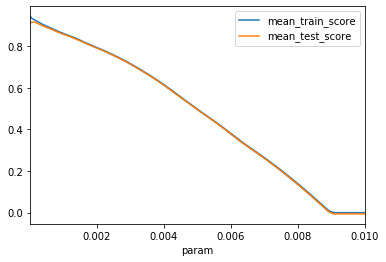

In [45]:
lasso_vis_df.plot(x = 'param', y = ['mean_train_score', 'mean_test_score'])

In [46]:
best_alpha = lasso_param_search.best_estimator_.get_params()['alpha']
print(best_alpha)

0.00010815187025522882


In [47]:
lasso_gs2 = Lasso(max_iter = 1e7, warm_start = True)
best_alpha1 = 0.00010815187025522882

In [3]:
delta = 0.0001*3
grid_params2 = [{'alpha': np.linspace(best_alpha1/10, best_alpha1 + delta, 10000)}]

NameError: name 'np' is not defined

In [55]:
lasso_param_search2 = GridSearchCV(estimator = lasso_gs2, 
                                  param_grid = grid_params2, cv=10, 
                                  return_train_score=True,
                                  scoring='r2', verbose=2)

In [ ]:
lasso_param_search2.fit(X_train, y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[CV] alpha=-0.0002918481297447712 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... alpha=-0.0002918481297447712, total=   1.1s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.0s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.0s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.0s
[CV] alpha=-0.0002918481297447712 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ..................... alpha=-0.0002918481297447712, total=   1.0s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.0s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.9s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.0s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.9s
[CV] alpha=-0.0002918481297447712 ....................................
[CV] ..................... alpha=-0.0002918481297447712, total=   0.9s
[CV] alpha=-0.0002910473289439704 ....................................
[CV] ..................... alpha=-0.0002910473289439704, total=   0.9s
[CV] alpha=-0.0002910473289439704 ....................................
[CV] .

[CV] ..................... alpha=-0.0002870433249399664, total=   1.0s
[CV] alpha=-0.0002870433249399664 ....................................
[CV] ..................... alpha=-0.0002870433249399664, total=   0.0s
[CV] alpha=-0.0002870433249399664 ....................................
[CV] ..................... alpha=-0.0002870433249399664, total=   0.9s
[CV] alpha=-0.0002870433249399664 ....................................
[CV] ..................... alpha=-0.0002870433249399664, total=   0.0s
[CV] alpha=-0.0002870433249399664 ....................................
[CV] ..................... alpha=-0.0002870433249399664, total=   1.0s
[CV] alpha=-0.0002870433249399664 ....................................
[CV] ..................... alpha=-0.0002870433249399664, total=   0.9s
[CV] alpha=-0.0002862425241391656 ....................................
[CV] ..................... alpha=-0.0002862425241391656, total=   0.9s
[CV] alpha=-0.0002862425241391656 ....................................
[CV] .

[CV] ..................... alpha=-0.0002822385201351616, total=   0.9s
[CV] alpha=-0.0002822385201351616 ....................................
[CV] ..................... alpha=-0.0002822385201351616, total=   0.0s
[CV] alpha=-0.0002822385201351616 ....................................
[CV] ..................... alpha=-0.0002822385201351616, total=   0.9s
[CV] alpha=-0.0002822385201351616 ....................................
[CV] ..................... alpha=-0.0002822385201351616, total=   0.0s
[CV] alpha=-0.0002822385201351616 ....................................
[CV] ..................... alpha=-0.0002822385201351616, total=   0.9s
[CV] alpha=-0.0002822385201351616 ....................................
[CV] ..................... alpha=-0.0002822385201351616, total=   0.9s
[CV] alpha=-0.0002814377193343608 ....................................
[CV] ..................... alpha=-0.0002814377193343608, total=   1.0s
[CV] alpha=-0.0002814377193343608 ....................................
[CV] .

[CV] .................... alpha=-0.00027743371533035674, total=   1.0s
[CV] alpha=-0.00027743371533035674 ...................................
[CV] .................... alpha=-0.00027743371533035674, total=   0.0s
[CV] alpha=-0.00027743371533035674 ...................................
[CV] .................... alpha=-0.00027743371533035674, total=   0.9s
[CV] alpha=-0.00027743371533035674 ...................................
[CV] .................... alpha=-0.00027743371533035674, total=   0.0s
[CV] alpha=-0.00027743371533035674 ...................................
[CV] .................... alpha=-0.00027743371533035674, total=   0.9s
[CV] alpha=-0.00027743371533035674 ...................................
[CV] .................... alpha=-0.00027743371533035674, total=   1.0s
[CV] alpha=-0.00027663291452955594 ...................................
[CV] .................... alpha=-0.00027663291452955594, total=   1.0s
[CV] alpha=-0.00027663291452955594 ...................................
[CV] .

[CV] .................... alpha=-0.00027262891052555195, total=   0.9s
[CV] alpha=-0.00027262891052555195 ...................................
[CV] .................... alpha=-0.00027262891052555195, total=   0.0s
[CV] alpha=-0.00027262891052555195 ...................................
[CV] .................... alpha=-0.00027262891052555195, total=   0.9s
[CV] alpha=-0.00027262891052555195 ...................................
[CV] .................... alpha=-0.00027262891052555195, total=   0.0s
[CV] alpha=-0.00027262891052555195 ...................................
[CV] .................... alpha=-0.00027262891052555195, total=   0.9s
[CV] alpha=-0.00027262891052555195 ...................................
[CV] .................... alpha=-0.00027262891052555195, total=   0.9s
[CV] alpha=-0.00027182810972475115 ...................................
[CV] .................... alpha=-0.00027182810972475115, total=   0.9s
[CV] alpha=-0.00027182810972475115 ...................................
[CV] .

[CV] .................... alpha=-0.00026782410572074715, total=   0.9s
[CV] alpha=-0.00026782410572074715 ...................................
[CV] .................... alpha=-0.00026782410572074715, total=   0.0s
[CV] alpha=-0.00026782410572074715 ...................................
[CV] .................... alpha=-0.00026782410572074715, total=   0.9s
[CV] alpha=-0.00026782410572074715 ...................................
[CV] .................... alpha=-0.00026782410572074715, total=   0.0s
[CV] alpha=-0.00026782410572074715 ...................................
[CV] .................... alpha=-0.00026782410572074715, total=   0.9s
[CV] alpha=-0.00026782410572074715 ...................................
[CV] .................... alpha=-0.00026782410572074715, total=   0.9s
[CV] alpha=-0.00026702330491994636 ...................................
[CV] .................... alpha=-0.00026702330491994636, total=   0.9s
[CV] alpha=-0.00026702330491994636 ...................................
[CV] .

[CV] .................... alpha=-0.00026301930091594236, total=   0.9s
[CV] alpha=-0.00026301930091594236 ...................................
[CV] .................... alpha=-0.00026301930091594236, total=   0.0s
[CV] alpha=-0.00026301930091594236 ...................................
[CV] .................... alpha=-0.00026301930091594236, total=   1.0s
[CV] alpha=-0.00026301930091594236 ...................................
[CV] .................... alpha=-0.00026301930091594236, total=   0.0s
[CV] alpha=-0.00026301930091594236 ...................................
[CV] .................... alpha=-0.00026301930091594236, total=   0.9s
[CV] alpha=-0.00026301930091594236 ...................................
[CV] .................... alpha=-0.00026301930091594236, total=   0.9s
[CV] alpha=-0.00026221850011514156 ...................................
[CV] .................... alpha=-0.00026221850011514156, total=   0.9s
[CV] alpha=-0.00026221850011514156 ...................................
[CV] .

[CV] ..................... alpha=-0.0002582144961111375, total=   0.9s
[CV] alpha=-0.0002582144961111375 ....................................
[CV] ..................... alpha=-0.0002582144961111375, total=   0.0s
[CV] alpha=-0.0002582144961111375 ....................................
[CV] ..................... alpha=-0.0002582144961111375, total=   1.0s
[CV] alpha=-0.0002582144961111375 ....................................
[CV] ..................... alpha=-0.0002582144961111375, total=   0.0s
[CV] alpha=-0.0002582144961111375 ....................................
[CV] ..................... alpha=-0.0002582144961111375, total=   0.9s
[CV] alpha=-0.0002582144961111375 ....................................
[CV] ..................... alpha=-0.0002582144961111375, total=   1.0s
[CV] alpha=-0.0002574136953103367 ....................................
[CV] ..................... alpha=-0.0002574136953103367, total=   1.0s
[CV] alpha=-0.0002574136953103367 ....................................
[CV] .

[CV] ..................... alpha=-0.0002534096913063327, total=   0.9s
[CV] alpha=-0.0002534096913063327 ....................................
[CV] ..................... alpha=-0.0002534096913063327, total=   0.0s
[CV] alpha=-0.0002534096913063327 ....................................
[CV] ..................... alpha=-0.0002534096913063327, total=   0.9s
[CV] alpha=-0.0002534096913063327 ....................................
[CV] ..................... alpha=-0.0002534096913063327, total=   0.0s
[CV] alpha=-0.0002534096913063327 ....................................
[CV] ..................... alpha=-0.0002534096913063327, total=   0.9s
[CV] alpha=-0.0002534096913063327 ....................................
[CV] ..................... alpha=-0.0002534096913063327, total=   1.0s
[CV] alpha=-0.0002526088905055319 ....................................
[CV] ..................... alpha=-0.0002526088905055319, total=   0.9s
[CV] alpha=-0.0002526088905055319 ....................................
[CV] .

[CV] .................... alpha=-0.00024860488650152793, total=   0.9s
[CV] alpha=-0.00024860488650152793 ...................................
[CV] .................... alpha=-0.00024860488650152793, total=   0.0s
[CV] alpha=-0.00024860488650152793 ...................................
[CV] .................... alpha=-0.00024860488650152793, total=   0.9s
[CV] alpha=-0.00024860488650152793 ...................................
[CV] .................... alpha=-0.00024860488650152793, total=   0.0s
[CV] alpha=-0.00024860488650152793 ...................................
[CV] .................... alpha=-0.00024860488650152793, total=   0.9s
[CV] alpha=-0.00024860488650152793 ...................................
[CV] .................... alpha=-0.00024860488650152793, total=   0.9s
[CV] alpha=-0.00024780408570072713 ...................................
[CV] .................... alpha=-0.00024780408570072713, total=   1.0s
[CV] alpha=-0.00024780408570072713 ...................................
[CV] .

[CV] .................... alpha=-0.00024380008169672313, total=   0.9s
[CV] alpha=-0.00024380008169672313 ...................................
[CV] .................... alpha=-0.00024380008169672313, total=   0.0s
[CV] alpha=-0.00024380008169672313 ...................................
[CV] .................... alpha=-0.00024380008169672313, total=   0.9s
[CV] alpha=-0.00024380008169672313 ...................................
[CV] .................... alpha=-0.00024380008169672313, total=   0.0s
[CV] alpha=-0.00024380008169672313 ...................................
[CV] .................... alpha=-0.00024380008169672313, total=   0.9s
[CV] alpha=-0.00024380008169672313 ...................................
[CV] .................... alpha=-0.00024380008169672313, total=   0.9s
[CV] alpha=-0.00024299928089592234 ...................................
[CV] .................... alpha=-0.00024299928089592234, total=   0.9s
[CV] alpha=-0.00024299928089592234 ...................................
[CV] .

[CV] .................... alpha=-0.00023899527689191831, total=   0.9s
[CV] alpha=-0.00023899527689191831 ...................................
[CV] .................... alpha=-0.00023899527689191831, total=   0.0s
[CV] alpha=-0.00023899527689191831 ...................................
[CV] .................... alpha=-0.00023899527689191831, total=   0.9s
[CV] alpha=-0.00023899527689191831 ...................................
[CV] .................... alpha=-0.00023899527689191831, total=   0.0s
[CV] alpha=-0.00023899527689191831 ...................................
[CV] .................... alpha=-0.00023899527689191831, total=   0.9s
[CV] alpha=-0.00023899527689191831 ...................................
[CV] .................... alpha=-0.00023899527689191831, total=   0.9s
[CV] alpha=-0.00023819447609111751 ...................................
[CV] .................... alpha=-0.00023819447609111751, total=   0.9s
[CV] alpha=-0.00023819447609111751 ...................................
[CV] .

[CV] .................... alpha=-0.00023419047208711352, total=   0.9s
[CV] alpha=-0.00023419047208711352 ...................................
[CV] .................... alpha=-0.00023419047208711352, total=   0.0s
[CV] alpha=-0.00023419047208711352 ...................................
[CV] .................... alpha=-0.00023419047208711352, total=   0.9s
[CV] alpha=-0.00023419047208711352 ...................................
[CV] .................... alpha=-0.00023419047208711352, total=   0.0s
[CV] alpha=-0.00023419047208711352 ...................................
[CV] .................... alpha=-0.00023419047208711352, total=   0.9s
[CV] alpha=-0.00023419047208711352 ...................................
[CV] .................... alpha=-0.00023419047208711352, total=   1.0s
[CV] alpha=-0.00023338967128631272 ...................................
[CV] .................... alpha=-0.00023338967128631272, total=   0.9s
[CV] alpha=-0.00023338967128631272 ...................................
[CV] .

[CV] ..................... alpha=-0.0002293856672823087, total=   0.9s
[CV] alpha=-0.0002293856672823087 ....................................
[CV] ..................... alpha=-0.0002293856672823087, total=   0.0s
[CV] alpha=-0.0002293856672823087 ....................................
[CV] ..................... alpha=-0.0002293856672823087, total=   0.9s
[CV] alpha=-0.0002293856672823087 ....................................
[CV] ..................... alpha=-0.0002293856672823087, total=   0.0s
[CV] alpha=-0.0002293856672823087 ....................................
[CV] ..................... alpha=-0.0002293856672823087, total=   0.9s
[CV] alpha=-0.0002293856672823087 ....................................
[CV] ..................... alpha=-0.0002293856672823087, total=   1.0s
[CV] alpha=-0.0002285848664815079 ....................................
[CV] ..................... alpha=-0.0002285848664815079, total=   1.0s
[CV] alpha=-0.0002285848664815079 ....................................
[CV] .

[CV] ..................... alpha=-0.0002245808624775039, total=   0.9s
[CV] alpha=-0.0002245808624775039 ....................................
[CV] ..................... alpha=-0.0002245808624775039, total=   0.0s
[CV] alpha=-0.0002245808624775039 ....................................
[CV] ..................... alpha=-0.0002245808624775039, total=   0.9s
[CV] alpha=-0.0002245808624775039 ....................................
[CV] ..................... alpha=-0.0002245808624775039, total=   0.0s
[CV] alpha=-0.0002245808624775039 ....................................
[CV] ..................... alpha=-0.0002245808624775039, total=   0.9s
[CV] alpha=-0.0002245808624775039 ....................................
[CV] ..................... alpha=-0.0002245808624775039, total=   0.9s
[CV] alpha=-0.0002237800616767031 ....................................
[CV] ..................... alpha=-0.0002237800616767031, total=   0.9s
[CV] alpha=-0.0002237800616767031 ....................................
[CV] .

[CV] ..................... alpha=-0.0002197760576726991, total=   0.9s
[CV] alpha=-0.0002197760576726991 ....................................
[CV] ..................... alpha=-0.0002197760576726991, total=   0.0s
[CV] alpha=-0.0002197760576726991 ....................................
[CV] ..................... alpha=-0.0002197760576726991, total=   0.9s
[CV] alpha=-0.0002197760576726991 ....................................
[CV] ..................... alpha=-0.0002197760576726991, total=   0.0s
[CV] alpha=-0.0002197760576726991 ....................................
[CV] ..................... alpha=-0.0002197760576726991, total=   0.9s
[CV] alpha=-0.0002197760576726991 ....................................
[CV] ..................... alpha=-0.0002197760576726991, total=   1.0s
[CV] alpha=-0.00021897525687189831 ...................................
[CV] .................... alpha=-0.00021897525687189831, total=   1.0s
[CV] alpha=-0.00021897525687189831 ...................................
[CV] .

[CV] ..................... alpha=-0.0002149712528678943, total=   1.0s
[CV] alpha=-0.0002149712528678943 ....................................
[CV] ..................... alpha=-0.0002149712528678943, total=   0.0s
[CV] alpha=-0.0002149712528678943 ....................................
[CV] ..................... alpha=-0.0002149712528678943, total=   0.9s
[CV] alpha=-0.0002149712528678943 ....................................
[CV] ..................... alpha=-0.0002149712528678943, total=   0.0s
[CV] alpha=-0.0002149712528678943 ....................................
[CV] ..................... alpha=-0.0002149712528678943, total=   0.9s
[CV] alpha=-0.0002149712528678943 ....................................
[CV] ..................... alpha=-0.0002149712528678943, total=   1.0s
[CV] alpha=-0.0002141704520670935 ....................................
[CV] ..................... alpha=-0.0002141704520670935, total=   1.0s
[CV] alpha=-0.0002141704520670935 ....................................
[CV] .

[CV] ..................... alpha=-0.0002101664480630895, total=   1.0s
[CV] alpha=-0.0002101664480630895 ....................................
[CV] ..................... alpha=-0.0002101664480630895, total=   0.0s
[CV] alpha=-0.0002101664480630895 ....................................
[CV] ..................... alpha=-0.0002101664480630895, total=   1.0s
[CV] alpha=-0.0002101664480630895 ....................................
[CV] ..................... alpha=-0.0002101664480630895, total=   0.0s
[CV] alpha=-0.0002101664480630895 ....................................
[CV] ..................... alpha=-0.0002101664480630895, total=   1.1s
[CV] alpha=-0.0002101664480630895 ....................................
[CV] ..................... alpha=-0.0002101664480630895, total=   1.1s
[CV] alpha=-0.0002093656472622887 ....................................
[CV] ..................... alpha=-0.0002093656472622887, total=   1.0s
[CV] alpha=-0.0002093656472622887 ....................................
[CV] .

[CV] .................... alpha=-0.00020536164325828468, total=   0.9s
[CV] alpha=-0.00020536164325828468 ...................................
[CV] .................... alpha=-0.00020536164325828468, total=   0.0s
[CV] alpha=-0.00020536164325828468 ...................................
[CV] .................... alpha=-0.00020536164325828468, total=   0.9s
[CV] alpha=-0.00020536164325828468 ...................................
[CV] .................... alpha=-0.00020536164325828468, total=   0.0s
[CV] alpha=-0.00020536164325828468 ...................................
[CV] .................... alpha=-0.00020536164325828468, total=   0.9s
[CV] alpha=-0.00020536164325828468 ...................................
[CV] .................... alpha=-0.00020536164325828468, total=   0.9s
[CV] alpha=-0.00020456084245748388 ...................................
[CV] .................... alpha=-0.00020456084245748388, total=   0.9s
[CV] alpha=-0.00020456084245748388 ...................................
[CV] .

[CV] .................... alpha=-0.00020055683845347989, total=   0.9s
[CV] alpha=-0.00020055683845347989 ...................................
[CV] .................... alpha=-0.00020055683845347989, total=   0.0s
[CV] alpha=-0.00020055683845347989 ...................................
[CV] .................... alpha=-0.00020055683845347989, total=   0.9s
[CV] alpha=-0.00020055683845347989 ...................................
[CV] .................... alpha=-0.00020055683845347989, total=   0.0s
[CV] alpha=-0.00020055683845347989 ...................................
[CV] .................... alpha=-0.00020055683845347989, total=   0.9s
[CV] alpha=-0.00020055683845347989 ...................................
[CV] .................... alpha=-0.00020055683845347989, total=   0.9s
[CV] alpha=-0.0001997560376526791 ....................................
[CV] ..................... alpha=-0.0001997560376526791, total=   0.9s
[CV] alpha=-0.0001997560376526791 ....................................
[CV] .

[CV] ..................... alpha=-0.0001957520336486751, total=   1.2s
[CV] alpha=-0.0001957520336486751 ....................................
[CV] ..................... alpha=-0.0001957520336486751, total=   0.0s
[CV] alpha=-0.0001957520336486751 ....................................
[CV] ..................... alpha=-0.0001957520336486751, total=   1.0s
[CV] alpha=-0.0001957520336486751 ....................................
[CV] ..................... alpha=-0.0001957520336486751, total=   0.0s
[CV] alpha=-0.0001957520336486751 ....................................
[CV] ..................... alpha=-0.0001957520336486751, total=   1.0s
[CV] alpha=-0.0001957520336486751 ....................................
[CV] ..................... alpha=-0.0001957520336486751, total=   1.2s
[CV] alpha=-0.0001949512328478743 ....................................
[CV] ..................... alpha=-0.0001949512328478743, total=   1.1s
[CV] alpha=-0.0001949512328478743 ....................................
[CV] .

[CV] .................... alpha=-0.00019094722884387027, total=   0.9s
[CV] alpha=-0.00019094722884387027 ...................................
[CV] .................... alpha=-0.00019094722884387027, total=   0.0s
[CV] alpha=-0.00019094722884387027 ...................................
[CV] .................... alpha=-0.00019094722884387027, total=   0.9s
[CV] alpha=-0.00019094722884387027 ...................................
[CV] .................... alpha=-0.00019094722884387027, total=   0.0s
[CV] alpha=-0.00019094722884387027 ...................................
[CV] .................... alpha=-0.00019094722884387027, total=   0.9s
[CV] alpha=-0.00019094722884387027 ...................................
[CV] .................... alpha=-0.00019094722884387027, total=   0.9s
[CV] alpha=-0.00019014642804306947 ...................................
[CV] .................... alpha=-0.00019014642804306947, total=   1.0s
[CV] alpha=-0.00019014642804306947 ...................................
[CV] .

[CV] .................... alpha=-0.00018614242403906545, total=   1.0s
[CV] alpha=-0.00018614242403906545 ...................................
[CV] .................... alpha=-0.00018614242403906545, total=   0.0s
[CV] alpha=-0.00018614242403906545 ...................................
[CV] .................... alpha=-0.00018614242403906545, total=   1.0s
[CV] alpha=-0.00018614242403906545 ...................................
[CV] .................... alpha=-0.00018614242403906545, total=   0.0s
[CV] alpha=-0.00018614242403906545 ...................................
[CV] .................... alpha=-0.00018614242403906545, total=   1.0s
[CV] alpha=-0.00018614242403906545 ...................................
[CV] .................... alpha=-0.00018614242403906545, total=   1.0s
[CV] alpha=-0.00018534162323826465 ...................................
[CV] .................... alpha=-0.00018534162323826465, total=   1.0s
[CV] alpha=-0.00018534162323826465 ...................................
[CV] .

[CV] .................... alpha=-0.00018133761923426066, total=   0.9s
[CV] alpha=-0.00018133761923426066 ...................................
[CV] .................... alpha=-0.00018133761923426066, total=   0.0s
[CV] alpha=-0.00018133761923426066 ...................................
[CV] .................... alpha=-0.00018133761923426066, total=   0.9s
[CV] alpha=-0.00018133761923426066 ...................................
[CV] .................... alpha=-0.00018133761923426066, total=   0.0s
[CV] alpha=-0.00018133761923426066 ...................................
[CV] .................... alpha=-0.00018133761923426066, total=   0.9s
[CV] alpha=-0.00018133761923426066 ...................................
[CV] .................... alpha=-0.00018133761923426066, total=   0.9s
[CV] alpha=-0.00018053681843345986 ...................................
[CV] .................... alpha=-0.00018053681843345986, total=   1.1s
[CV] alpha=-0.00018053681843345986 ...................................
[CV] .

[CV] .................... alpha=-0.00017653281442945587, total=   0.9s
[CV] alpha=-0.00017653281442945587 ...................................
[CV] .................... alpha=-0.00017653281442945587, total=   0.0s
[CV] alpha=-0.00017653281442945587 ...................................
[CV] .................... alpha=-0.00017653281442945587, total=   0.9s
[CV] alpha=-0.00017653281442945587 ...................................
[CV] .................... alpha=-0.00017653281442945587, total=   0.0s
[CV] alpha=-0.00017653281442945587 ...................................
[CV] .................... alpha=-0.00017653281442945587, total=   0.9s
[CV] alpha=-0.00017653281442945587 ...................................
[CV] .................... alpha=-0.00017653281442945587, total=   0.9s
[CV] alpha=-0.00017573201362865507 ...................................
[CV] .................... alpha=-0.00017573201362865507, total=   1.2s
[CV] alpha=-0.00017573201362865507 ...................................
[CV] .

[CV] .................... alpha=-0.00017172800962465107, total=   0.9s
[CV] alpha=-0.00017172800962465107 ...................................
[CV] .................... alpha=-0.00017172800962465107, total=   0.0s
[CV] alpha=-0.00017172800962465107 ...................................
[CV] .................... alpha=-0.00017172800962465107, total=   0.9s
[CV] alpha=-0.00017172800962465107 ...................................
[CV] .................... alpha=-0.00017172800962465107, total=   0.0s
[CV] alpha=-0.00017172800962465107 ...................................
[CV] .................... alpha=-0.00017172800962465107, total=   0.9s
[CV] alpha=-0.00017172800962465107 ...................................
[CV] .................... alpha=-0.00017172800962465107, total=   0.9s
[CV] alpha=-0.00017092720882385027 ...................................
[CV] .................... alpha=-0.00017092720882385027, total=   1.3s
[CV] alpha=-0.00017092720882385027 ...................................
[CV] .

[CV] .................... alpha=-0.00016692320481984625, total=   0.9s
[CV] alpha=-0.00016692320481984625 ...................................
[CV] .................... alpha=-0.00016692320481984625, total=   0.0s
[CV] alpha=-0.00016692320481984625 ...................................
[CV] .................... alpha=-0.00016692320481984625, total=   0.9s
[CV] alpha=-0.00016692320481984625 ...................................
[CV] .................... alpha=-0.00016692320481984625, total=   0.0s
[CV] alpha=-0.00016692320481984625 ...................................
[CV] .................... alpha=-0.00016692320481984625, total=   0.9s
[CV] alpha=-0.00016692320481984625 ...................................
[CV] .................... alpha=-0.00016692320481984625, total=   0.9s
[CV] alpha=-0.00016612240401904545 ...................................
[CV] .................... alpha=-0.00016612240401904545, total=   1.4s
[CV] alpha=-0.00016612240401904545 ...................................
[CV] .

[CV] .................... alpha=-0.00016211840001504146, total=   0.9s
[CV] alpha=-0.00016211840001504146 ...................................
[CV] .................... alpha=-0.00016211840001504146, total=   0.0s
[CV] alpha=-0.00016211840001504146 ...................................
[CV] .................... alpha=-0.00016211840001504146, total=   0.9s
[CV] alpha=-0.00016211840001504146 ...................................
[CV] .................... alpha=-0.00016211840001504146, total=   0.0s
[CV] alpha=-0.00016211840001504146 ...................................
[CV] .................... alpha=-0.00016211840001504146, total=   0.9s
[CV] alpha=-0.00016211840001504146 ...................................
[CV] .................... alpha=-0.00016211840001504146, total=   0.9s
[CV] alpha=-0.00016131759921424066 ...................................
[CV] .................... alpha=-0.00016131759921424066, total=   1.5s
[CV] alpha=-0.00016131759921424066 ...................................
[CV] .

[CV] .................... alpha=-0.00015731359521023664, total=   0.9s
[CV] alpha=-0.00015731359521023664 ...................................
[CV] .................... alpha=-0.00015731359521023664, total=   0.0s
[CV] alpha=-0.00015731359521023664 ...................................
[CV] .................... alpha=-0.00015731359521023664, total=   0.9s
[CV] alpha=-0.00015731359521023664 ...................................
[CV] .................... alpha=-0.00015731359521023664, total=   0.0s
[CV] alpha=-0.00015731359521023664 ...................................
[CV] .................... alpha=-0.00015731359521023664, total=   1.0s
[CV] alpha=-0.00015731359521023664 ...................................
[CV] .................... alpha=-0.00015731359521023664, total=   0.9s
[CV] alpha=-0.00015651279440943584 ...................................
[CV] .................... alpha=-0.00015651279440943584, total=   1.6s
[CV] alpha=-0.00015651279440943584 ...................................
[CV] .

[CV] .................... alpha=-0.00015250879040543184, total=   0.9s
[CV] alpha=-0.00015250879040543184 ...................................
[CV] .................... alpha=-0.00015250879040543184, total=   0.0s
[CV] alpha=-0.00015250879040543184 ...................................
[CV] .................... alpha=-0.00015250879040543184, total=   0.9s
[CV] alpha=-0.00015250879040543184 ...................................
[CV] .................... alpha=-0.00015250879040543184, total=   0.0s
[CV] alpha=-0.00015250879040543184 ...................................
[CV] .................... alpha=-0.00015250879040543184, total=   0.9s
[CV] alpha=-0.00015250879040543184 ...................................
[CV] .................... alpha=-0.00015250879040543184, total=   0.9s
[CV] alpha=-0.00015170798960463105 ...................................
[CV] .................... alpha=-0.00015170798960463105, total=   1.8s
[CV] alpha=-0.00015170798960463105 ...................................
[CV] .

[CV] .................... alpha=-0.00014770398560062702, total=   0.9s
[CV] alpha=-0.00014770398560062702 ...................................
[CV] .................... alpha=-0.00014770398560062702, total=   0.0s
[CV] alpha=-0.00014770398560062702 ...................................
[CV] .................... alpha=-0.00014770398560062702, total=   0.9s
[CV] alpha=-0.00014770398560062702 ...................................
[CV] .................... alpha=-0.00014770398560062702, total=   0.0s
[CV] alpha=-0.00014770398560062702 ...................................
[CV] .................... alpha=-0.00014770398560062702, total=   0.9s
[CV] alpha=-0.00014770398560062702 ...................................
[CV] .................... alpha=-0.00014770398560062702, total=   0.9s
[CV] alpha=-0.00014690318479982623 ...................................
[CV] .................... alpha=-0.00014690318479982623, total=   1.9s
[CV] alpha=-0.00014690318479982623 ...................................
[CV] .

[CV] .................... alpha=-0.00014289918079582223, total=   0.9s
[CV] alpha=-0.00014289918079582223 ...................................
[CV] .................... alpha=-0.00014289918079582223, total=   0.0s
[CV] alpha=-0.00014289918079582223 ...................................
[CV] .................... alpha=-0.00014289918079582223, total=   0.9s
[CV] alpha=-0.00014289918079582223 ...................................
[CV] .................... alpha=-0.00014289918079582223, total=   0.0s
[CV] alpha=-0.00014289918079582223 ...................................
[CV] .................... alpha=-0.00014289918079582223, total=   1.0s
[CV] alpha=-0.00014289918079582223 ...................................
[CV] .................... alpha=-0.00014289918079582223, total=   1.0s
[CV] alpha=-0.00014209837999502143 ...................................
[CV] .................... alpha=-0.00014209837999502143, total=   2.1s
[CV] alpha=-0.00014209837999502143 ...................................
[CV] .

[CV] ..................... alpha=-0.0001380943759910174, total=   0.9s
[CV] alpha=-0.0001380943759910174 ....................................
[CV] ..................... alpha=-0.0001380943759910174, total=   0.0s
[CV] alpha=-0.0001380943759910174 ....................................
[CV] ..................... alpha=-0.0001380943759910174, total=   0.9s
[CV] alpha=-0.0001380943759910174 ....................................
[CV] ..................... alpha=-0.0001380943759910174, total=   0.0s
[CV] alpha=-0.0001380943759910174 ....................................
[CV] ..................... alpha=-0.0001380943759910174, total=   0.9s
[CV] alpha=-0.0001380943759910174 ....................................
[CV] ..................... alpha=-0.0001380943759910174, total=   0.9s
[CV] alpha=-0.0001372935751902166 ....................................
[CV] ..................... alpha=-0.0001372935751902166, total=   2.2s
[CV] alpha=-0.0001372935751902166 ....................................
[CV] .

[CV] .................... alpha=-0.00013328957118621262, total=   1.0s
[CV] alpha=-0.00013328957118621262 ...................................
[CV] .................... alpha=-0.00013328957118621262, total=   0.0s
[CV] alpha=-0.00013328957118621262 ...................................
[CV] .................... alpha=-0.00013328957118621262, total=   0.9s
[CV] alpha=-0.00013328957118621262 ...................................
[CV] .................... alpha=-0.00013328957118621262, total=   0.0s
[CV] alpha=-0.00013328957118621262 ...................................
[CV] .................... alpha=-0.00013328957118621262, total=   1.0s
[CV] alpha=-0.00013328957118621262 ...................................
[CV] .................... alpha=-0.00013328957118621262, total=   0.9s
[CV] alpha=-0.00013248877038541182 ...................................
[CV] .................... alpha=-0.00013248877038541182, total=   2.4s
[CV] alpha=-0.00013248877038541182 ...................................
[CV] .

[CV] .................... alpha=-0.00012848476638140782, total=   0.9s
[CV] alpha=-0.00012848476638140782 ...................................
[CV] .................... alpha=-0.00012848476638140782, total=   0.0s
[CV] alpha=-0.00012848476638140782 ...................................
[CV] .................... alpha=-0.00012848476638140782, total=   0.9s
[CV] alpha=-0.00012848476638140782 ...................................
[CV] .................... alpha=-0.00012848476638140782, total=   0.0s
[CV] alpha=-0.00012848476638140782 ...................................
[CV] .................... alpha=-0.00012848476638140782, total=   0.9s
[CV] alpha=-0.00012848476638140782 ...................................
[CV] .................... alpha=-0.00012848476638140782, total=   0.9s
[CV] alpha=-0.00012768396558060702 ...................................
[CV] .................... alpha=-0.00012768396558060702, total=   2.7s
[CV] alpha=-0.00012768396558060702 ...................................
[CV] .

[CV] ...................... alpha=-0.000123679961576603, total=   0.9s
[CV] alpha=-0.000123679961576603 .....................................
[CV] ...................... alpha=-0.000123679961576603, total=   0.0s
[CV] alpha=-0.000123679961576603 .....................................
[CV] ...................... alpha=-0.000123679961576603, total=   0.9s
[CV] alpha=-0.000123679961576603 .....................................
[CV] ...................... alpha=-0.000123679961576603, total=   0.0s
[CV] alpha=-0.000123679961576603 .....................................
[CV] ...................... alpha=-0.000123679961576603, total=   0.9s
[CV] alpha=-0.000123679961576603 .....................................
[CV] ...................... alpha=-0.000123679961576603, total=   0.9s
[CV] alpha=-0.0001228791607758022 ....................................
[CV] ..................... alpha=-0.0001228791607758022, total=   3.0s
[CV] alpha=-0.0001228791607758022 ....................................
[CV] .

[CV] .................... alpha=-0.00011887515677179821, total=   0.9s
[CV] alpha=-0.00011887515677179821 ...................................
[CV] .................... alpha=-0.00011887515677179821, total=   0.0s
[CV] alpha=-0.00011887515677179821 ...................................
[CV] .................... alpha=-0.00011887515677179821, total=   0.9s
[CV] alpha=-0.00011887515677179821 ...................................
[CV] .................... alpha=-0.00011887515677179821, total=   0.0s
[CV] alpha=-0.00011887515677179821 ...................................
[CV] .................... alpha=-0.00011887515677179821, total=   0.9s
[CV] alpha=-0.00011887515677179821 ...................................
[CV] .................... alpha=-0.00011887515677179821, total=   0.9s
[CV] alpha=-0.00011807435597099741 ...................................
[CV] .................... alpha=-0.00011807435597099741, total=   3.3s
[CV] alpha=-0.00011807435597099741 ...................................
[CV] .

[CV] .................... alpha=-0.00011407035196699339, total=   0.9s
[CV] alpha=-0.00011407035196699339 ...................................
[CV] .................... alpha=-0.00011407035196699339, total=   0.0s
[CV] alpha=-0.00011407035196699339 ...................................
[CV] .................... alpha=-0.00011407035196699339, total=   0.9s
[CV] alpha=-0.00011407035196699339 ...................................
[CV] .................... alpha=-0.00011407035196699339, total=   0.0s
[CV] alpha=-0.00011407035196699339 ...................................
[CV] .................... alpha=-0.00011407035196699339, total=   0.9s
[CV] alpha=-0.00011407035196699339 ...................................
[CV] .................... alpha=-0.00011407035196699339, total=   1.0s
[CV] alpha=-0.00011326955116619259 ...................................
[CV] .................... alpha=-0.00011326955116619259, total=   3.5s
[CV] alpha=-0.00011326955116619259 ...................................
[CV] .

[CV] ..................... alpha=-0.0001092655471621886, total=   0.9s
[CV] alpha=-0.0001092655471621886 ....................................
[CV] ..................... alpha=-0.0001092655471621886, total=   0.0s
[CV] alpha=-0.0001092655471621886 ....................................
[CV] ..................... alpha=-0.0001092655471621886, total=   0.9s
[CV] alpha=-0.0001092655471621886 ....................................
[CV] ..................... alpha=-0.0001092655471621886, total=   0.0s
[CV] alpha=-0.0001092655471621886 ....................................
[CV] ..................... alpha=-0.0001092655471621886, total=   0.9s
[CV] alpha=-0.0001092655471621886 ....................................
[CV] ..................... alpha=-0.0001092655471621886, total=   0.9s
[CV] alpha=-0.0001084647463613878 ....................................
[CV] ..................... alpha=-0.0001084647463613878, total=   3.9s
[CV] alpha=-0.0001084647463613878 ....................................
[CV] .

[CV] ..................... alpha=-0.0001044607423573838, total=   0.9s
[CV] alpha=-0.0001044607423573838 ....................................
[CV] ..................... alpha=-0.0001044607423573838, total=   0.0s
[CV] alpha=-0.0001044607423573838 ....................................
[CV] ..................... alpha=-0.0001044607423573838, total=   0.9s
[CV] alpha=-0.0001044607423573838 ....................................
[CV] ..................... alpha=-0.0001044607423573838, total=   0.0s
[CV] alpha=-0.0001044607423573838 ....................................
[CV] ..................... alpha=-0.0001044607423573838, total=   1.0s
[CV] alpha=-0.0001044607423573838 ....................................
[CV] ..................... alpha=-0.0001044607423573838, total=   0.9s
[CV] alpha=-0.00010365994155658298 ...................................
[CV] .................... alpha=-0.00010365994155658298, total=   4.3s
[CV] alpha=-0.00010365994155658298 ...................................
[CV] .

[CV] ..................... alpha=-9.965593755257898e-05, total=   1.0s
[CV] alpha=-9.965593755257898e-05 ....................................
[CV] ..................... alpha=-9.965593755257898e-05, total=   0.0s
[CV] alpha=-9.965593755257898e-05 ....................................
[CV] ..................... alpha=-9.965593755257898e-05, total=   0.9s
[CV] alpha=-9.965593755257898e-05 ....................................
[CV] ..................... alpha=-9.965593755257898e-05, total=   0.0s
[CV] alpha=-9.965593755257898e-05 ....................................
[CV] ..................... alpha=-9.965593755257898e-05, total=   0.9s
[CV] alpha=-9.965593755257898e-05 ....................................
[CV] ..................... alpha=-9.965593755257898e-05, total=   0.9s
[CV] alpha=-9.885513675177818e-05 ....................................
[CV] ..................... alpha=-9.885513675177818e-05, total=   4.9s
[CV] alpha=-9.885513675177818e-05 ....................................
[CV] .

[CV] ..................... alpha=-9.485113274777419e-05, total=   0.9s
[CV] alpha=-9.485113274777419e-05 ....................................
[CV] ..................... alpha=-9.485113274777419e-05, total=   0.0s
[CV] alpha=-9.485113274777419e-05 ....................................
[CV] ..................... alpha=-9.485113274777419e-05, total=   0.9s
[CV] alpha=-9.485113274777419e-05 ....................................
[CV] ..................... alpha=-9.485113274777419e-05, total=   0.0s
[CV] alpha=-9.485113274777419e-05 ....................................
[CV] ..................... alpha=-9.485113274777419e-05, total=   0.9s
[CV] alpha=-9.485113274777419e-05 ....................................
[CV] ..................... alpha=-9.485113274777419e-05, total=   0.9s
[CV] alpha=-9.405033194697339e-05 ....................................
[CV] ..................... alpha=-9.405033194697339e-05, total=   5.3s
[CV] alpha=-9.405033194697339e-05 ....................................
[CV] .

[CV] ..................... alpha=-9.004632794296937e-05, total=   0.9s
[CV] alpha=-9.004632794296937e-05 ....................................
[CV] ..................... alpha=-9.004632794296937e-05, total=   0.0s
[CV] alpha=-9.004632794296937e-05 ....................................
[CV] ..................... alpha=-9.004632794296937e-05, total=   1.0s
[CV] alpha=-9.004632794296937e-05 ....................................
[CV] ..................... alpha=-9.004632794296937e-05, total=   0.0s
[CV] alpha=-9.004632794296937e-05 ....................................
[CV] ..................... alpha=-9.004632794296937e-05, total=   1.0s
[CV] alpha=-9.004632794296937e-05 ....................................
[CV] ..................... alpha=-9.004632794296937e-05, total=   0.9s
[CV] alpha=-8.924552714216857e-05 ....................................
[CV] ..................... alpha=-8.924552714216857e-05, total=   6.0s
[CV] alpha=-8.924552714216857e-05 ....................................
[CV] .

[CV] ..................... alpha=-8.524152313816458e-05, total=   0.9s
[CV] alpha=-8.524152313816458e-05 ....................................
[CV] ..................... alpha=-8.524152313816458e-05, total=   0.0s
[CV] alpha=-8.524152313816458e-05 ....................................
[CV] ..................... alpha=-8.524152313816458e-05, total=   1.0s
[CV] alpha=-8.524152313816458e-05 ....................................
[CV] ..................... alpha=-8.524152313816458e-05, total=   0.0s
[CV] alpha=-8.524152313816458e-05 ....................................
[CV] ..................... alpha=-8.524152313816458e-05, total=   1.0s
[CV] alpha=-8.524152313816458e-05 ....................................
[CV] ..................... alpha=-8.524152313816458e-05, total=   1.0s
[CV] alpha=-8.444072233736378e-05 ....................................
[CV] ..................... alpha=-8.444072233736378e-05, total=   6.7s
[CV] alpha=-8.444072233736378e-05 ....................................
[CV] .

[CV] ..................... alpha=-8.043671833335975e-05, total=   0.9s
[CV] alpha=-8.043671833335975e-05 ....................................
[CV] ..................... alpha=-8.043671833335975e-05, total=   0.0s
[CV] alpha=-8.043671833335975e-05 ....................................
[CV] ..................... alpha=-8.043671833335975e-05, total=   1.0s
[CV] alpha=-8.043671833335975e-05 ....................................
[CV] ..................... alpha=-8.043671833335975e-05, total=   0.0s
[CV] alpha=-8.043671833335975e-05 ....................................
[CV] ..................... alpha=-8.043671833335975e-05, total=   1.0s
[CV] alpha=-8.043671833335975e-05 ....................................
[CV] ..................... alpha=-8.043671833335975e-05, total=   1.0s
[CV] alpha=-7.963591753255896e-05 ....................................
[CV] ..................... alpha=-7.963591753255896e-05, total=   7.9s
[CV] alpha=-7.963591753255896e-05 ....................................
[CV] .

[CV] ..................... alpha=-7.563191352855496e-05, total=   0.9s
[CV] alpha=-7.563191352855496e-05 ....................................
[CV] ..................... alpha=-7.563191352855496e-05, total=   0.0s
[CV] alpha=-7.563191352855496e-05 ....................................
[CV] ..................... alpha=-7.563191352855496e-05, total=   0.9s
[CV] alpha=-7.563191352855496e-05 ....................................
[CV] ..................... alpha=-7.563191352855496e-05, total=   0.0s
[CV] alpha=-7.563191352855496e-05 ....................................
[CV] ..................... alpha=-7.563191352855496e-05, total=   0.9s
[CV] alpha=-7.563191352855496e-05 ....................................
[CV] ..................... alpha=-7.563191352855496e-05, total=   0.9s
[CV] alpha=-7.483111272775416e-05 ....................................
[CV] ..................... alpha=-7.483111272775416e-05, total=   9.2s
[CV] alpha=-7.483111272775416e-05 ....................................
[CV] .

[CV] ..................... alpha=-7.082710872375017e-05, total=   1.0s
[CV] alpha=-7.082710872375017e-05 ....................................
[CV] ..................... alpha=-7.082710872375017e-05, total=   0.0s
[CV] alpha=-7.082710872375017e-05 ....................................
[CV] ..................... alpha=-7.082710872375017e-05, total=   1.0s
[CV] alpha=-7.082710872375017e-05 ....................................
[CV] ..................... alpha=-7.082710872375017e-05, total=   0.0s
[CV] alpha=-7.082710872375017e-05 ....................................
[CV] ..................... alpha=-7.082710872375017e-05, total=   0.9s
[CV] alpha=-7.082710872375017e-05 ....................................
[CV] ..................... alpha=-7.082710872375017e-05, total=   0.9s
[CV] alpha=-7.002630792294937e-05 ....................................
[CV] ..................... alpha=-7.002630792294937e-05, total=  10.0s
[CV] alpha=-7.002630792294937e-05 ....................................
[CV] .

[CV] ..................... alpha=-6.602230391894535e-05, total=   0.9s
[CV] alpha=-6.602230391894535e-05 ....................................
[CV] ..................... alpha=-6.602230391894535e-05, total=   0.0s
[CV] alpha=-6.602230391894535e-05 ....................................
[CV] ..................... alpha=-6.602230391894535e-05, total=   0.9s
[CV] alpha=-6.602230391894535e-05 ....................................
[CV] ..................... alpha=-6.602230391894535e-05, total=   0.0s
[CV] alpha=-6.602230391894535e-05 ....................................
[CV] ..................... alpha=-6.602230391894535e-05, total=   1.0s
[CV] alpha=-6.602230391894535e-05 ....................................
[CV] ..................... alpha=-6.602230391894535e-05, total=   0.9s
[CV] alpha=-6.522150311814455e-05 ....................................
[CV] ..................... alpha=-6.522150311814455e-05, total=  11.9s
[CV] alpha=-6.522150311814455e-05 ....................................
[CV] .

[CV] ..................... alpha=-6.121749911414055e-05, total=   0.9s
[CV] alpha=-6.121749911414055e-05 ....................................
[CV] ..................... alpha=-6.121749911414055e-05, total=   0.0s
[CV] alpha=-6.121749911414055e-05 ....................................
[CV] ..................... alpha=-6.121749911414055e-05, total=   0.9s
[CV] alpha=-6.121749911414055e-05 ....................................
[CV] ..................... alpha=-6.121749911414055e-05, total=   0.0s
[CV] alpha=-6.121749911414055e-05 ....................................
[CV] ..................... alpha=-6.121749911414055e-05, total=   0.9s
[CV] alpha=-6.121749911414055e-05 ....................................
[CV] ..................... alpha=-6.121749911414055e-05, total=   0.9s
[CV] alpha=-6.0416698313339756e-05 ...................................
[CV] .................... alpha=-6.0416698313339756e-05, total=  14.2s
[CV] alpha=-6.0416698313339756e-05 ...................................
[CV] .

[CV] .................... alpha=-5.6412694309335734e-05, total=   0.9s
[CV] alpha=-5.6412694309335734e-05 ...................................
[CV] .................... alpha=-5.6412694309335734e-05, total=   0.0s
[CV] alpha=-5.6412694309335734e-05 ...................................
[CV] .................... alpha=-5.6412694309335734e-05, total=   0.9s
[CV] alpha=-5.6412694309335734e-05 ...................................
[CV] .................... alpha=-5.6412694309335734e-05, total=   0.0s
[CV] alpha=-5.6412694309335734e-05 ...................................
[CV] .................... alpha=-5.6412694309335734e-05, total=   1.0s
[CV] alpha=-5.6412694309335734e-05 ...................................
[CV] .................... alpha=-5.6412694309335734e-05, total=   0.9s
[CV] alpha=-5.5611893508534935e-05 ...................................
[CV] .................... alpha=-5.5611893508534935e-05, total=  16.2s
[CV] alpha=-5.5611893508534935e-05 ...................................
[CV] .

[CV] ..................... alpha=-5.160788950453094e-05, total=   0.9s
[CV] alpha=-5.160788950453094e-05 ....................................
[CV] ..................... alpha=-5.160788950453094e-05, total=   0.0s
[CV] alpha=-5.160788950453094e-05 ....................................
[CV] ..................... alpha=-5.160788950453094e-05, total=   0.9s
[CV] alpha=-5.160788950453094e-05 ....................................
[CV] ..................... alpha=-5.160788950453094e-05, total=   0.0s
[CV] alpha=-5.160788950453094e-05 ....................................
[CV] ..................... alpha=-5.160788950453094e-05, total=   0.9s
[CV] alpha=-5.160788950453094e-05 ....................................
[CV] ..................... alpha=-5.160788950453094e-05, total=   1.0s
[CV] alpha=-5.080708870373014e-05 ....................................
[CV] ..................... alpha=-5.080708870373014e-05, total=  19.7s
[CV] alpha=-5.080708870373014e-05 ....................................
[CV] .

[CV] ..................... alpha=-4.680308469972612e-05, total=   1.1s
[CV] alpha=-4.680308469972612e-05 ....................................
[CV] ..................... alpha=-4.680308469972612e-05, total=   0.0s
[CV] alpha=-4.680308469972612e-05 ....................................
[CV] ..................... alpha=-4.680308469972612e-05, total=   1.1s
[CV] alpha=-4.680308469972612e-05 ....................................
[CV] ..................... alpha=-4.680308469972612e-05, total=   0.0s
[CV] alpha=-4.680308469972612e-05 ....................................
[CV] ..................... alpha=-4.680308469972612e-05, total=   1.1s
[CV] alpha=-4.680308469972612e-05 ....................................
[CV] ..................... alpha=-4.680308469972612e-05, total=   1.0s
[CV] alpha=-4.600228389892532e-05 ....................................
[CV] ..................... alpha=-4.600228389892532e-05, total=  29.0s
[CV] alpha=-4.600228389892532e-05 ....................................
[CV] .

[CV] ..................... alpha=-4.199827989492133e-05, total=   1.1s
[CV] alpha=-4.199827989492133e-05 ....................................
[CV] ..................... alpha=-4.199827989492133e-05, total=   0.0s
[CV] alpha=-4.199827989492133e-05 ....................................
[CV] ..................... alpha=-4.199827989492133e-05, total=   0.9s
[CV] alpha=-4.199827989492133e-05 ....................................
[CV] ..................... alpha=-4.199827989492133e-05, total=   0.0s
[CV] alpha=-4.199827989492133e-05 ....................................
[CV] ..................... alpha=-4.199827989492133e-05, total=   0.9s
[CV] alpha=-4.199827989492133e-05 ....................................
[CV] ..................... alpha=-4.199827989492133e-05, total=   0.9s
[CV] alpha=-4.119747909412053e-05 ....................................
[CV] ..................... alpha=-4.119747909412053e-05, total=  32.4s
[CV] alpha=-4.119747909412053e-05 ....................................
[CV] .

[CV] .................... alpha=-3.7193475090116534e-05, total=   1.0s
[CV] alpha=-3.7193475090116534e-05 ...................................
[CV] .................... alpha=-3.7193475090116534e-05, total=   0.0s
[CV] alpha=-3.7193475090116534e-05 ...................................
[CV] .................... alpha=-3.7193475090116534e-05, total=   0.9s
[CV] alpha=-3.7193475090116534e-05 ...................................
[CV] .................... alpha=-3.7193475090116534e-05, total=   0.0s
[CV] alpha=-3.7193475090116534e-05 ...................................
[CV] .................... alpha=-3.7193475090116534e-05, total=   1.0s
[CV] alpha=-3.7193475090116534e-05 ...................................
[CV] .................... alpha=-3.7193475090116534e-05, total=   1.0s
[CV] alpha=-3.6392674289315735e-05 ...................................
[CV] .................... alpha=-3.6392674289315735e-05, total=  41.9s
[CV] alpha=-3.6392674289315735e-05 ...................................
[CV] .

[CV] ..................... alpha=-3.238867028531174e-05, total=   1.0s
[CV] alpha=-3.238867028531174e-05 ....................................
[CV] ..................... alpha=-3.238867028531174e-05, total=   0.0s
[CV] alpha=-3.238867028531174e-05 ....................................
[CV] ..................... alpha=-3.238867028531174e-05, total=   1.1s
[CV] alpha=-3.238867028531174e-05 ....................................
[CV] ..................... alpha=-3.238867028531174e-05, total=   0.0s
[CV] alpha=-3.238867028531174e-05 ....................................
[CV] ..................... alpha=-3.238867028531174e-05, total=   1.2s
[CV] alpha=-3.238867028531174e-05 ....................................
[CV] ..................... alpha=-3.238867028531174e-05, total=   1.1s
[CV] alpha=-3.158786948451094e-05 ....................................
[CV] ..................... alpha=-3.158786948451094e-05, total=  56.0s
[CV] alpha=-3.158786948451094e-05 ....................................
[CV] .

[CV] .................... alpha=-2.7583865480506893e-05, total=   1.0s
[CV] alpha=-2.7583865480506893e-05 ...................................
[CV] .................... alpha=-2.7583865480506893e-05, total=   0.0s
[CV] alpha=-2.7583865480506893e-05 ...................................
[CV] .................... alpha=-2.7583865480506893e-05, total=   1.0s
[CV] alpha=-2.7583865480506893e-05 ...................................
[CV] .................... alpha=-2.7583865480506893e-05, total=   0.0s
[CV] alpha=-2.7583865480506893e-05 ...................................
[CV] .................... alpha=-2.7583865480506893e-05, total=   1.0s
[CV] alpha=-2.7583865480506893e-05 ...................................
[CV] .................... alpha=-2.7583865480506893e-05, total=   1.0s
[CV] alpha=-2.6783064679706094e-05 ...................................
[CV] .................... alpha=-2.6783064679706094e-05, total= 1.4min
[CV] alpha=-2.6783064679706094e-05 ...................................
[CV] .

[CV] ...................... alpha=-2.27790606757021e-05, total=   0.9s
[CV] alpha=-2.27790606757021e-05 .....................................
[CV] ...................... alpha=-2.27790606757021e-05, total=   0.0s
[CV] alpha=-2.27790606757021e-05 .....................................
[CV] ...................... alpha=-2.27790606757021e-05, total=   1.0s
[CV] alpha=-2.27790606757021e-05 .....................................
[CV] ...................... alpha=-2.27790606757021e-05, total=   0.0s
[CV] alpha=-2.27790606757021e-05 .....................................
[CV] ...................... alpha=-2.27790606757021e-05, total=   1.0s
[CV] alpha=-2.27790606757021e-05 .....................................
[CV] ...................... alpha=-2.27790606757021e-05, total=   0.9s
[CV] alpha=-2.19782598749013e-05 .....................................
[CV] ...................... alpha=-2.19782598749013e-05, total= 1.9min
[CV] alpha=-2.19782598749013e-05 .....................................
[CV] .

[CV] .................... alpha=-1.7974255870897306e-05, total=   0.9s
[CV] alpha=-1.7974255870897306e-05 ...................................
[CV] .................... alpha=-1.7974255870897306e-05, total=   0.0s
[CV] alpha=-1.7974255870897306e-05 ...................................
[CV] .................... alpha=-1.7974255870897306e-05, total=   1.0s
[CV] alpha=-1.7974255870897306e-05 ...................................
[CV] .................... alpha=-1.7974255870897306e-05, total=   0.0s
[CV] alpha=-1.7974255870897306e-05 ...................................
[CV] .................... alpha=-1.7974255870897306e-05, total=   0.9s
[CV] alpha=-1.7974255870897306e-05 ...................................
[CV] .................... alpha=-1.7974255870897306e-05, total=   0.9s
[CV] alpha=-1.7173455070096507e-05 ...................................
[CV] .................... alpha=-1.7173455070096507e-05, total= 3.1min
[CV] alpha=-1.7173455070096507e-05 ...................................
[CV] .

[CV] .................... alpha=-1.3169451066092513e-05, total=   0.9s
[CV] alpha=-1.3169451066092513e-05 ...................................
[CV] .................... alpha=-1.3169451066092513e-05, total=   0.0s
[CV] alpha=-1.3169451066092513e-05 ...................................
[CV] .................... alpha=-1.3169451066092513e-05, total=   0.9s
[CV] alpha=-1.3169451066092513e-05 ...................................
[CV] .................... alpha=-1.3169451066092513e-05, total=   0.0s
[CV] alpha=-1.3169451066092513e-05 ...................................
[CV] .................... alpha=-1.3169451066092513e-05, total=   0.9s
[CV] alpha=-1.3169451066092513e-05 ...................................
[CV] .................... alpha=-1.3169451066092513e-05, total=   1.0s
[CV] alpha=-1.2368650265291714e-05 ...................................
[CV] .................... alpha=-1.2368650265291714e-05, total= 5.9min
[CV] alpha=-1.2368650265291714e-05 ...................................
[CV] .

In [47]:
mean_test_score = lasso_param_search2.cv_results_['mean_test_score']
std_test_score = lasso_param_search2.cv_results_['std_test_score']
mean_train_score = lasso_param_search2.cv_results_['mean_train_score']
std_train_score = lasso_param_search2.cv_results_['std_train_score']

params = list(map(lambda s: s['alpha'], lasso_param_search2.cv_results_['params']))

In [48]:
lasso_vis_df = pd.DataFrame({'param': params, 'mean_test_score': mean_test_score,
                             'std_test_score': std_test_score, 
                             'mean_train_score':mean_train_score,
                             'std_train_score': std_train_score})

In [ ]:
# lasso_vis_df.to_csv(f"lasso_coefs{'lasso_param_search2_1.csv', index = False)

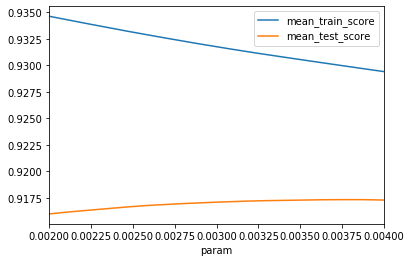

In [49]:
lasso_vis_df.plot(x = 'param', y = ['mean_train_score', 'mean_test_score'])

In [50]:
best_alpha_2 = lasso_param_search2.best_estimator_.get_params()['alpha']

In [52]:
print(best_alpha)

0.0038058058058058055


# Submission

In [51]:
y_predict = np.expm1(lasso_param_search2.predict(X_test.loc[:,X_test.columns != 'Id']))

submission = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': y_predict})
submission

submission.to_csv('submission_lasso.csv',index=False)